In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib import rc
from sklearn import tree, datasets
from sklearn.model_selection import (cross_val_score, learning_curve, 
                                     ShuffleSplit)
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import Imputer
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
import sqlite3    # Python interface for SQLite databases
from sklearn.metrics import roc_curve, auc
import seaborn as sns   
import math
import shap
import xgboost
from sklearn.model_selection import train_test_split

/home/parfait/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


### Chargement de la base de données

In [2]:
%reload_ext sql
%sql sqlite:///geoxilia.db

'Connected: @geoxilia.db'

In [3]:
%%sql
SELECT distinct(LITHO), DESCRIPTION
FROM geoxilia_well
WHERE DESCRIPTION LIKE '%shale%'
OR DESCRIPTION LIKE '%Shale%'

 * sqlite:///geoxilia.db
Done.


[('CLCL', 'Upper Hot Shale Member'),
 ('CLCL', 'Lower Hot Shale Member'),
 ('CLST', 'Oxfordian Shale'),
 ('CLCL', 'Oxfordian Shale'),
 ('SLCL', 'Mid Shale'),
 ('SLCL', 'Oxfordian Shale'),
 ('CLST', 'Mid Shale'),
 ('BLAS', 'Black Shales'),
 ('SHAL', 'Mid Shale'),
 ('CLST', 'Black Shales'),
 ('SHAL', 'Black Shales'),
 ('MDST', 'Lower Cretaceous Shale Group'),
 ('MDST', 'Volkim Shale Group'),
 ('MDST', 'Black Shale Group'),
 ('MDST', 'Oxfordian Shale Group'),
 ('MDST', 'Mid Shale'),
 ('MDST', 'Ladys Walk Shale'),
 ('SHAL', 'Oxfordian Shale'),
 ('OXSH', 'Oxfordian Shale'),
 ('SHAL', 'Ladys Walk Shale'),
 ('SLSH', 'Slow Shale'),
 ('CLST', 'Ladys Walk Shale'),
 ('MDST', 'Black Shales'),
 ('MDST', 'Oxfordian Slow Shale')]

#### Chargement du fichier csv et traitement

In [4]:
argiles = 'UHSM|LHSM|OXSH|MISH|BLAS|KLSG|VKSG|BLSG|OXSG|LAWS|SLSH|OXSS|VALH|TRBS|ZECH|CHER|ROTC|DURB|TRCH|BOCL|KIMM|STCR|INOX|PLNM|RODB|SOLA|HEAT|VHCK'

In [5]:
data_geox = pd.read_csv('geoxilia_clean.csv', na_values = ['-9999.0', '-999.2500', '0.0'])

Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.


In [6]:
data_geox = data_geox.drop(columns=['Unnamed: 0'])

In [7]:
data_geox.head()

,DEPTH,GR,CAL,DCOR,DENS,DTC,DTS,PE,PHIN,RESD,RESM,RESS,RESMIC,SP,DEPTH_M,WELL,LITHO,LAT,LONG
0,1988.928,28.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-11.0,1988.928,10/1-A-23,SAND,NaN,NaN
1,1989.080,28.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-11.5,1989.080,10/1-A-23,SAND,NaN,NaN
2,1989.232,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.5,1989.232,10/1-A-23,SAND,NaN,NaN
3,1989.384,26.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6.5,1989.384,10/1-A-23,SAND,NaN,NaN
4,1989.536,26.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-13.5,1989.536,10/1-A-23,SAND,NaN,NaN


In [8]:
data_geox['LITHO'][data_geox['LITHO'].str.contains('CLCL|CLST|UHSM|LHSM|OXSH|MISH|BLAS|KLSG|VKSG|BLSG|OXSG|LAWS|SLSH|OXSS|CLAY|MDST')] = 1
data_geox['LITHO'][data_geox['LITHO'] != 1] = 0
data_geox['LITHO'] = data_geox['LITHO'].astype('int')


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [9]:
data_geox.head()

,DEPTH,GR,CAL,DCOR,DENS,DTC,DTS,PE,PHIN,RESD,RESM,RESS,RESMIC,SP,DEPTH_M,WELL,LITHO,LAT,LONG
0,1988.928,28.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-11.0,1988.928,10/1-A-23,0,NaN,NaN
1,1989.080,28.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-11.5,1989.080,10/1-A-23,0,NaN,NaN
2,1989.232,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.5,1989.232,10/1-A-23,0,NaN,NaN
3,1989.384,26.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6.5,1989.384,10/1-A-23,0,NaN,NaN
4,1989.536,26.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-13.5,1989.536,10/1-A-23,0,NaN,NaN


In [10]:
columns = data_geox.columns

In [11]:
data_geox_ml = pd.DataFrame(data_geox,columns=columns)

In [12]:
data_geox_ml = data_geox_ml.groupby(['WELL', 'DEPTH'], as_index=False).mean()

In [13]:
data_geox_ml[data_geox_ml['WELL'] == '10/1-A-23' ]

,WELL,DEPTH,GR,CAL,DCOR,DENS,DTC,DTS,PE,PHIN,RESD,RESM,RESS,RESMIC,SP,DEPTH_M,LITHO
7294,10/1-A-23,1988.928,29.282133,9.35,0.012,2.0021,NaN,NaN,NaN,0.216643,329.4760,4916.5684,NaN,NaN,-11.000,1988.928,0
7295,10/1-A-23,1989.080,28.387900,9.10,0.026,2.0154,NaN,NaN,NaN,0.175038,458.2495,8621.9473,NaN,NaN,-11.500,1989.080,0
7296,10/1-A-23,1989.232,26.313033,9.25,0.060,2.0031,NaN,NaN,NaN,0.135809,588.2173,10140.0000,NaN,NaN,-9.500,1989.232,0
7297,10/1-A-23,1989.384,27.309933,10.20,0.072,2.0195,NaN,NaN,NaN,0.133508,673.1532,53.2467,NaN,NaN,-6.500,1989.384,0
7298,10/1-A-23,1989.536,27.657067,10.70,0.026,2.0021,NaN,NaN,NaN,0.149649,79.6105,40.5047,NaN,NaN,-13.500,1989.536,0
7299,10/1-A-23,1989.688,29.669433,10.90,0.011,1.9856,NaN,NaN,NaN,0.169674,47.9102,41.8949,NaN,NaN,-20.000,1989.688,0
7300,10/1-A-23,1989.840,30.552867,11.10,0.003,1.9856,NaN,NaN,NaN,0.185385,43.1830,46.5920,NaN,NaN,-25.500,1989.840,0
7301,10/1-A-23,1989.992,30.135767,11.45,-0.004,1.9836,NaN,NaN,NaN,0.180312,58.9351,62.4321,NaN,NaN,-27.250,1989.992,0
7302,10/1-A-23,1990.144,29.707800,11.40,-0.009,1.9764,NaN,NaN,NaN,0.177826,101.3857,86.4385,NaN,NaN,-27.750,1990.144,0
7303,10/1-A-23,1990.296,30.093800,11.30,-0.021,1.9856,NaN,NaN,NaN,0.181928,179.6962,96.0715,NaN,NaN,-28.750,1990.296,0


In [14]:
data_geox_ml.head()

,WELL,DEPTH,GR,CAL,DCOR,DENS,DTC,DTS,PE,PHIN,RESD,RESM,RESS,RESMIC,SP,DEPTH_M,LITHO
0,10/1-A-10,2094.872,17.2000,8.48605,-0.275,2.426,72.0,NaN,NaN,0.168400,0.47420,0.19950,NaN,NaN,-22.2857,2094.872,0
1,10/1-A-10,2095.024,18.7058,8.56870,-0.275,2.392,72.0,NaN,NaN,0.182023,0.44160,0.20720,NaN,NaN,-20.0000,2095.024,0
2,10/1-A-10,2095.176,19.3092,8.62140,-0.275,2.378,80.3,NaN,NaN,0.171809,0.23975,0.20720,NaN,NaN,-18.2857,2095.176,0
3,10/1-A-10,2095.328,19.1081,8.71425,-0.275,2.330,75.4,NaN,NaN,0.154246,0.21250,0.19425,NaN,NaN,-16.5714,2095.328,0
4,10/1-A-10,2095.480,20.3536,8.93990,-0.168,2.216,72.1,NaN,NaN,0.141603,0.21080,0.19275,NaN,NaN,-15.1429,2095.480,0


In [15]:
data_geox_ml.dtypes

WELL        object
DEPTH      float64
GR         float64
CAL        float64
DCOR       float64
DENS       float64
DTC        float64
DTS        float64
PE         float64
PHIN       float64
RESD       float64
RESM       float64
RESS       float64
RESMIC     float64
SP         float64
DEPTH_M    float64
LITHO        int64
dtype: object

In [16]:
len(data_geox_ml)

472079

In [17]:
data_geox_ml_stat = pd.DataFrame(columns = ['champs', 'percent'])

In [18]:
for index, col in enumerate(columns[1:-3]):
    data_geox_ml_stat.loc[index, 'champs'] = col
    data_geox_ml_stat.loc[index, 'percent'] = round((((len(data_geox_ml) -  data_geox_ml[col].isna().sum())/(len(data_geox_ml)))*100), 2)

Text(0.5, 1.0, 'Pourcentage de valeurs non nulles par caractéristiques')

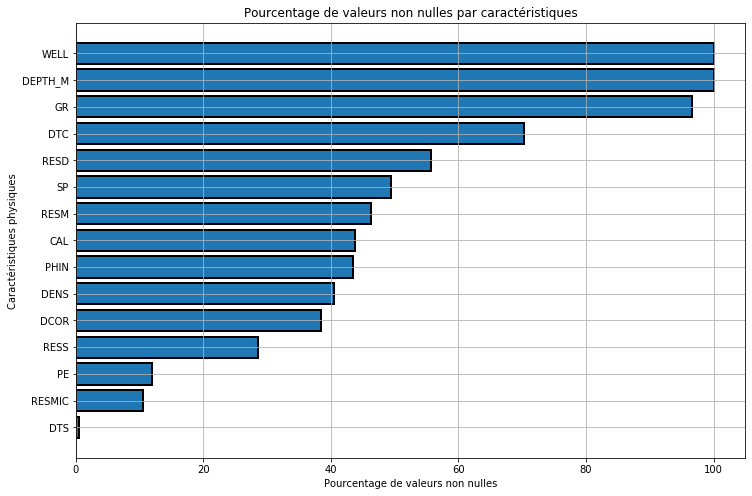

In [19]:
data_geox_ml_stat_sort = data_geox_ml_stat.sort_values(by ='percent')
fig = plt.figure(figsize=(12, 8))
plt.barh(data_geox_ml_stat_sort['champs'],data_geox_ml_stat_sort['percent'] , edgecolor='black', linewidth = 2)
xlabel = 'Pourcentage de valeurs non nulles'
ylabel = 'Caractéristiques physiques'
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.grid()
plt.title("Pourcentage de valeurs non nulles par caractéristiques")

#### GR et PHIN

In [20]:
data_geox_ml_all_1 = pd.DataFrame(data_geox_ml[(data_geox_ml['GR'].isna() != True) & (data_geox_ml['PHIN'].isna() != True)], columns=['GR', 'PHIN', 'LITHO'])

In [21]:
data_geox_ml_all_1.head()

,GR,PHIN,LITHO
0,17.2000,0.168400,0
1,18.7058,0.182023,0
2,19.3092,0.171809,0
3,19.1081,0.154246,0
4,20.3536,0.141603,0


In [22]:
data_geox_ml_all_1.shape

(202500, 3)

In [23]:
data_geox_ml_all_1.groupby(['LITHO']).count()

,GR,PHIN
LITHO,,
0,97970,97970
1,104530,104530


In [24]:
rapp_1 = round((data_geox_ml_all_1.shape[0]/len(data_geox_ml)) * 100, 2)

In [25]:
print(rapp_1)

42.9


In [26]:
data_geox_ml_all_2 = pd.DataFrame(data_geox_ml[(data_geox_ml['GR'].isna() != True) & (data_geox_ml['PHIN'].isna() != True) & (data_geox_ml['RESM'].isna() != True) & (data_geox_ml['RESD'].isna() != True) & (data_geox_ml['DTC'].isna() != True) & (data_geox_ml['DENS'].isna() != True) & (data_geox_ml['DCOR'].isna() != True) & (data_geox_ml['CAL'].isna() != True)], columns=['GR', 'PHIN', 'RESM', 'RESD', 'DTC', 'DENS', 'DCOR','CAL','LITHO'])

In [27]:
data_geox_ml_all_2.groupby(['LITHO']).count()

,GR,PHIN,RESM,RESD,DTC,DENS,DCOR,CAL
LITHO,,,,,,,,
0,36036,36036,36036,36036,36036,36036,36036,36036
1,43347,43347,43347,43347,43347,43347,43347,43347


In [28]:
rapp_2 = round((data_geox_ml_all_2.shape[0]/len(data_geox_ml)) * 100, 2)

In [29]:
print(rapp_2)

16.82


In [30]:
data_geox_ml_all_3 = pd.DataFrame(data_geox_ml[(data_geox_ml['GR'].isna() != True) & (data_geox_ml['PHIN'].isna() != True) & (data_geox_ml['SP'].isna() != True) & (data_geox_ml['RESM'].isna() != True) & (data_geox_ml['RESD'].isna() != True) & (data_geox_ml['DTC'].isna() != True) & (data_geox_ml['DENS'].isna() != True) & (data_geox_ml['DCOR'].isna() != True) & (data_geox_ml['CAL'].isna() != True)], columns=['GR', 'PHIN', 'SP', 'RESM', 'RESD', 'DTC', 'DENS', 'DCOR','CAL','LITHO'])

In [31]:
data_geox_ml_all_3.groupby(['LITHO']).count()

,GR,PHIN,SP,RESM,RESD,DTC,DENS,DCOR,CAL
LITHO,,,,,,,,,
0,31046,31046,31046,31046,31046,31046,31046,31046,31046
1,36397,36397,36397,36397,36397,36397,36397,36397,36397


In [32]:
rapp_3 = round((data_geox_ml_all_3.shape[0]/len(data_geox_ml)) * 100, 2)

In [33]:
print(rapp_3)

14.29


In [34]:
data_geox_ml_all_4 = pd.DataFrame(data_geox_ml[(data_geox_ml['GR'].isna() != True) & (data_geox_ml['PHIN'].isna() != True) & (data_geox_ml['PE'].isna() != True) & (data_geox_ml['RESM'].isna() != True) & (data_geox_ml['RESD'].isna() != True) & (data_geox_ml['DTC'].isna() != True) & (data_geox_ml['DENS'].isna() != True) & (data_geox_ml['DCOR'].isna() != True) & (data_geox_ml['CAL'].isna() != True)], columns=['GR', 'PHIN', 'PE', 'RESM', 'RESD', 'DTC', 'DENS', 'DCOR','CAL','LITHO'])

In [35]:
data_geox_ml_all_4.groupby(['LITHO']).count()

,GR,PHIN,PE,RESM,RESD,DTC,DENS,DCOR,CAL
LITHO,,,,,,,,,
0,9910,9910,9910,9910,9910,9910,9910,9910,9910
1,18407,18407,18407,18407,18407,18407,18407,18407,18407


In [36]:
rapp_4 = round((data_geox_ml_all_4.shape[0]/len(data_geox_ml)) * 100, 2)

In [37]:
print(rapp_4)

6.0


In [38]:
data_geox_ml_all_5 = pd.DataFrame(data_geox_ml[(data_geox_ml['GR'].isna() != True) & (data_geox_ml['PHIN'].isna() != True) & (data_geox_ml['SP'].isna() != True) & (data_geox_ml['RESM'].isna() != True) & (data_geox_ml['RESD'].isna() != True) & (data_geox_ml['DTC'].isna() != True) & (data_geox_ml['DENS'].isna() != True) & (data_geox_ml['DCOR'].isna() != True) & (data_geox_ml['CAL'].isna() != True) & (data_geox_ml['PE'].isna() != True)], columns=['GR', 'PHIN', 'SP', 'RESM', 'RESD', 'DTC', 'DENS', 'DCOR','CAL', 'PE','LITHO'])

In [39]:
data_geox_ml_all_5.groupby(['LITHO']).count()

,GR,PHIN,SP,RESM,RESD,DTC,DENS,DCOR,CAL,PE
LITHO,,,,,,,,,,
0,8329,8329,8329,8329,8329,8329,8329,8329,8329,8329
1,12301,12301,12301,12301,12301,12301,12301,12301,12301,12301


In [40]:
rapp_5 = round((data_geox_ml_all_5.shape[0]/len(data_geox_ml)) * 100, 2)

In [41]:
print(rapp_5)

4.37


Text(0.5, 1.0, 'Pourcentage de valeurs non nulles communes à plusieurs caractéristiques')

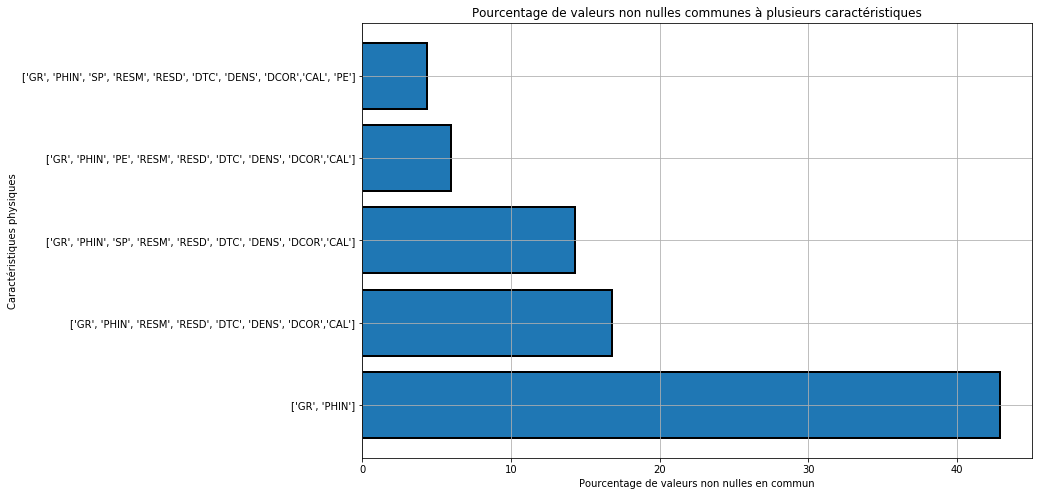

In [42]:
data_geox_ml_stat_sort = data_geox_ml_stat.sort_values(by ='percent')
fig = plt.figure(figsize=(12, 8))
plt.barh(["['GR', 'PHIN']", "['GR', 'PHIN', 'RESM', 'RESD', 'DTC', 'DENS', 'DCOR','CAL']", "['GR', 'PHIN', 'SP', 'RESM', 'RESD', 'DTC', 'DENS', 'DCOR','CAL']", "['GR', 'PHIN', 'PE', 'RESM', 'RESD', 'DTC', 'DENS', 'DCOR','CAL']","['GR', 'PHIN', 'SP', 'RESM', 'RESD', 'DTC', 'DENS', 'DCOR','CAL', 'PE']"],[rapp_1, rapp_2, rapp_3, rapp_4, rapp_5] , edgecolor='black', linewidth = 2)
xlabel = 'Pourcentage de valeurs non nulles en commun'
ylabel = 'Caractéristiques physiques'
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.grid()
plt.title("Pourcentage de valeurs non nulles communes à plusieurs caractéristiques")

## Analyse des logs 

# - GR

#### Suppression des données Nan

In [43]:
data_geox_ml_gr = data_geox_ml['GR'].dropna()

In [44]:
res_gr_1 = data_geox_ml_gr.describe()
res_gr_1

count    456227.000000
mean         71.487141
std          41.768034
min         -80.187500
25%          46.047700
50%          68.800000
75%          90.370000
max        1219.406250
Name: GR, dtype: float64

#### Histogramme du log GR 

Text(0.5, 1.0, 'Histogramme de distribution des valeurs GR')

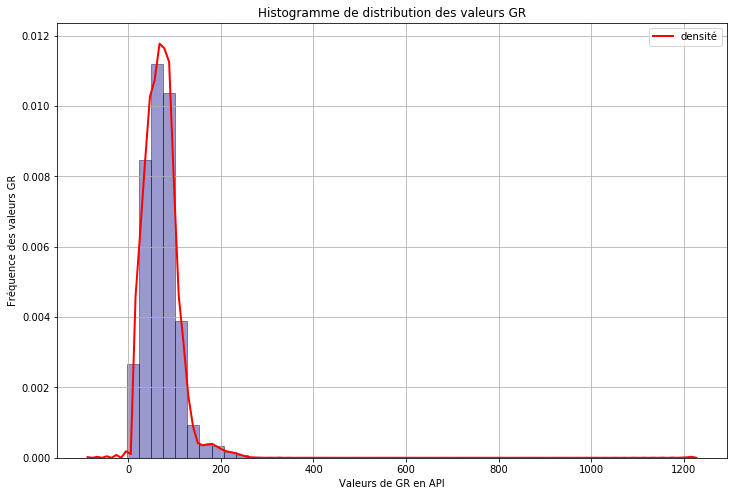

In [45]:
plt.figure(figsize=(12,8))
sns.distplot(data_geox_ml_gr, color = 'darkblue', hist = True, hist_kws={'edgecolor':'black'},kde=True, kde_kws = {'color': 'red', 'lw': 2, 'label':'densité'})
plt.grid()
plt.xlabel('Valeurs de GR en API')
plt.ylabel('Fréquence des valeurs GR')
plt.title('Histogramme de distribution des valeurs GR')

Text(0.5, 1.0, 'Histogramme de distribution des GR par label')

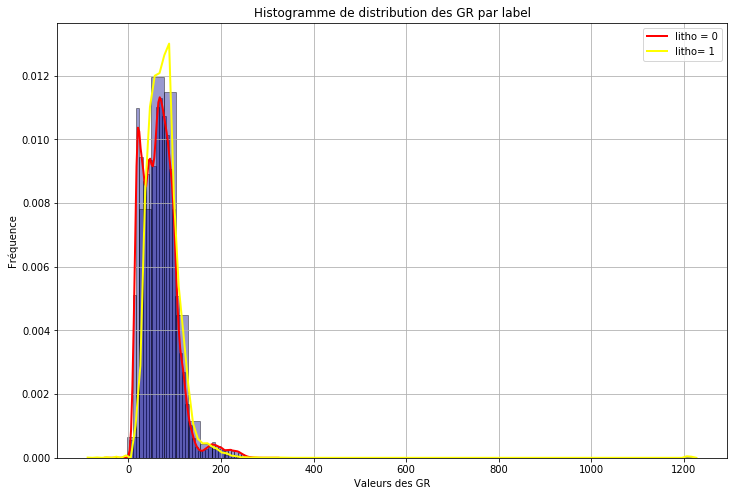

In [46]:
plt.figure(figsize=(12,8))
sns.distplot(data_geox_ml['GR'].dropna()[data_geox_ml['LITHO'] == 0], color = 'darkblue', hist = True, hist_kws={'edgecolor':'black'},kde=True, kde_kws = {'color': 'red', 'lw': 2, 'label':'litho = 0'})
sns.distplot(data_geox_ml['GR'].dropna()[data_geox_ml['LITHO'] == 1], color = 'darkblue', hist = True, hist_kws={'edgecolor':'black'},kde=True, kde_kws = {'color': 'yellow', 'lw': 2, 'label':'litho= 1'})
plt.grid()
plt.xlabel('Valeurs des GR')
plt.ylabel('Fréquence')
plt.title('Histogramme de distribution des GR par label')

Text(0, 0.5, 'Valeurs de Gamma Ray en API')

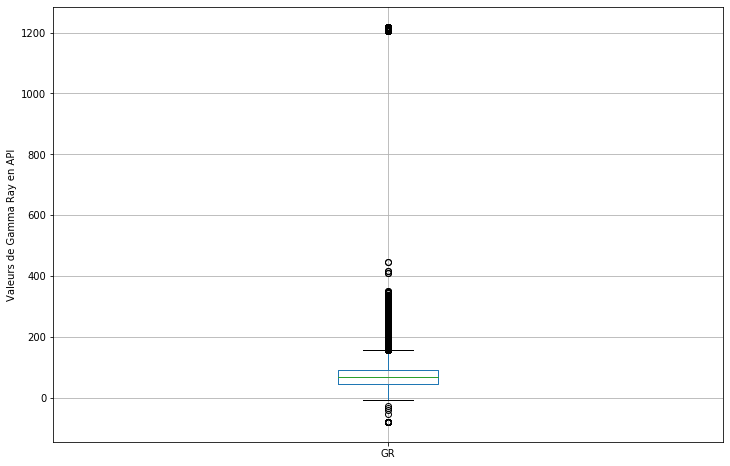

In [47]:
data_geox_ml_gr.plot.box(figsize=(12,8))
plt.grid()
plt.ylabel('Valeurs de Gamma Ray en API')

In [48]:
data_geox_ml['GR'][data_geox_ml['GR'] < 0].count()

61

In [49]:
data_geox_ml['GR'][data_geox_ml['GR'] > 400].count()

183

En visualisant ce box plot, on remarque que nous avons **61 valeurs de GR négatives**. De plus, on note aussi que  **183 valeurs sont trop élevées (>400)** --> comment traiter ces valeurs ???

In [50]:
data_geox_ml[data_geox_ml['GR'] > 400].head()

,WELL,DEPTH,GR,CAL,DCOR,DENS,DTC,DTS,PE,PHIN,RESD,RESM,RESS,RESMIC,SP,DEPTH_M,LITHO
111539,11/30A-10,3253.7401,415.70420,8.5871,0.0002,2.5410,58.3607,NaN,NaN,0.9073,NaN,NaN,NaN,NaN,NaN,991.739982,1
111540,11/30A-10,3253.8924,447.43620,8.5866,-0.0011,2.5398,58.2588,NaN,NaN,0.9003,NaN,NaN,NaN,NaN,NaN,991.786404,1
111541,11/30A-10,3254.0448,408.30360,8.5870,-0.0010,2.5413,57.8849,NaN,NaN,0.8983,NaN,NaN,NaN,NaN,NaN,991.832855,1
246996,11/30A-A6,5899.5000,1214.93750,1.2473,3.0938,1568.0000,93.5625,NaN,NaN,70.4375,273.46190,8.35350,NaN,NaN,-5.7188,1798.167600,1
246997,11/30A-A6,5900.0000,1216.34375,1.2473,3.0938,1568.0000,93.7500,NaN,NaN,70.4375,273.50295,8.39065,NaN,NaN,-5.2344,1798.320000,1


In [51]:
data_geox_ml['GR'][data_geox_ml['GR'] > 400].count()

183

In [52]:
data_geox_ml[data_geox_ml['GR'] < 0].head()

,WELL,DEPTH,GR,CAL,DCOR,DENS,DTC,DTS,PE,PHIN,RESD,RESM,RESS,RESMIC,SP,DEPTH_M,LITHO
429,10/1-A-11,2117.064,-1.213333,11.3,0.0181,2.026,NaN,NaN,NaN,0.222716,348.1978,401.2596,NaN,NaN,18.5000,2117.064,0
435,10/1-A-11,2117.976,-8.892100,8.0,0.1185,2.094,NaN,NaN,NaN,0.111163,414.9037,146.5839,NaN,NaN,26.5000,2117.976,0
436,10/1-A-11,2118.128,-34.112267,8.1,0.1325,2.116,NaN,NaN,NaN,0.115713,430.5242,149.3560,NaN,NaN,28.0000,2118.128,0
437,10/1-A-11,2118.280,-40.513133,8.1,0.1145,2.108,NaN,NaN,NaN,0.127661,446.5833,152.1270,NaN,NaN,29.0000,2118.280,0
147835,11/30A-A12,9980.000,-28.750000,NaN,NaN,NaN,66.5625,NaN,NaN,NaN,12.2188,14.6563,NaN,NaN,-7.4688,3041.904,1


In [53]:
res_gr_2 = data_geox_ml_gr[(data_geox_ml_gr > 0) & (data_geox_ml_gr < 400)].describe()
res_gr_2

count    455983.000000
mean         71.057050
std          35.177386
min           0.100000
25%          46.047700
50%          68.785100
75%          90.317550
max         350.346300
Name: GR, dtype: float64

In [54]:
data_gr = data_geox_ml[['GR', 'DEPTH_M']].dropna().sort_values(by = 'DEPTH_M')

In [55]:
data_gr.head()

,GR,DEPTH_M
7657,18.3129,122.0724
7658,19.3812,122.2248
7659,20.4624,122.3772
7660,21.5209,122.5296
7661,22.6655,122.6820


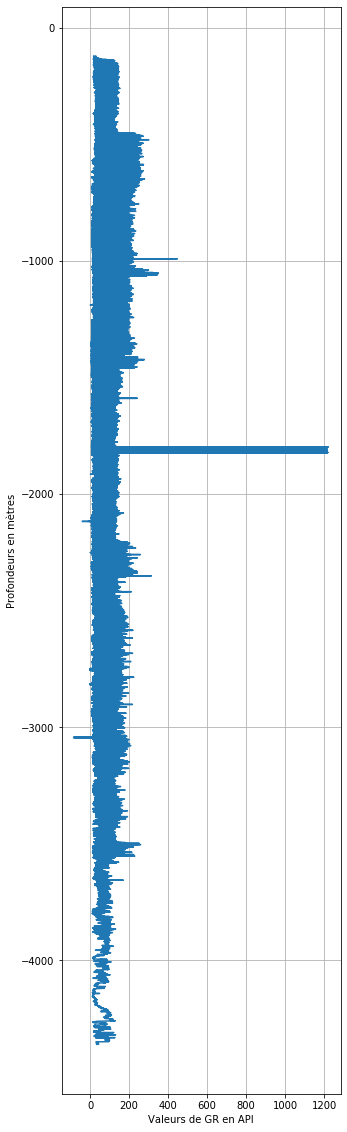

In [56]:
plt.figure(figsize=(5,20))
plt.plot(data_gr['GR'], data_gr['DEPTH_M']*-1)
plt.xlabel('Valeurs de GR en API')
plt.ylabel('Profondeurs en mètres')
plt.grid()

### Remplacer les valeurs de GR négatives et supérieures à 400 par la **moyenne de GR**

In [57]:
data_gr['GR'][data_gr['GR'] < 0] = res_gr_2['mean']
data_gr['GR'][data_gr['GR'] > 400] = res_gr_2['mean']

### Tester l'écart de nos données à la moyenne

In [58]:
data_gr['mean_std'] = np.abs(res_gr_2['mean'] - data_gr['GR'])

In [59]:
data_gr['3_std'] = 3*res_gr_2['std']

In [60]:
data_gr.head()

,GR,DEPTH_M,mean_std,3_std
7657,18.3129,122.0724,52.74415,105.532157
7658,19.3812,122.2248,51.67585,105.532157
7659,20.4624,122.3772,50.59465,105.532157
7660,21.5209,122.5296,49.53615,105.532157
7661,22.6655,122.6820,48.39155,105.532157


In [61]:
data_gr.shape

(456227, 4)

In [62]:
data_gr[data_gr['mean_std'] > data_gr['3_std']].count()

GR          7355
DEPTH_M     7355
mean_std    7355
3_std       7355
dtype: int64

On observe que **4904 données** sur les **302725** ont un écart à la moyenne supérieur à 3 fois l'écart type --> **comment traiter ces valeurs, faut-il les supprimer ?**

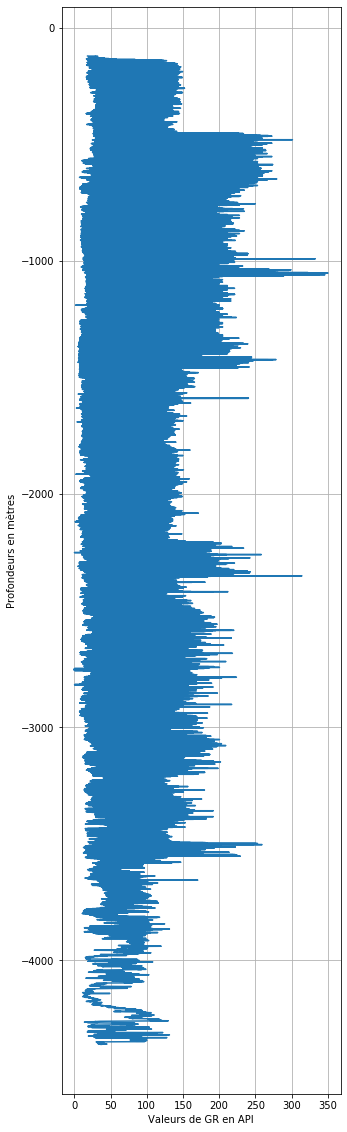

In [63]:
plt.figure(figsize=(5,20))
plt.plot(data_gr['GR'], data_gr['DEPTH_M']*-1)
plt.xlabel('Valeurs de GR en API')
plt.ylabel('Profondeurs en mètres')
plt.grid()

### Histogramme après modification 

Text(0.5, 1.0, 'Histogramme de distribution des GR par label')

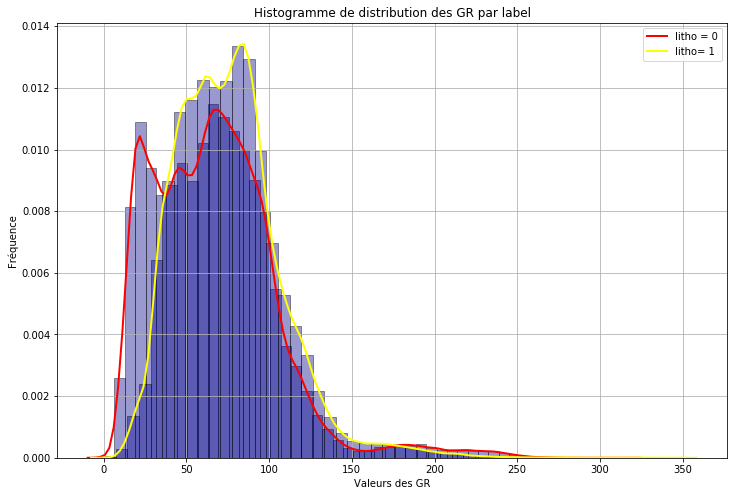

In [64]:
plt.figure(figsize=(12,8))
sns.distplot(data_gr['GR'].dropna()[data_geox_ml['LITHO'] == 0], color = 'darkblue', hist = True, hist_kws={'edgecolor':'black'},kde=True, kde_kws = {'color': 'red', 'lw': 2, 'label':'litho = 0'})
sns.distplot(data_gr['GR'].dropna()[data_geox_ml['LITHO'] == 1], color = 'darkblue', hist = True, hist_kws={'edgecolor':'black'},kde=True, kde_kws = {'color': 'yellow', 'lw': 2, 'label':'litho= 1'})
plt.grid()
plt.xlabel('Valeurs des GR')
plt.ylabel('Fréquence')
plt.title('Histogramme de distribution des GR par label')

# - CAL

#### Suppression des données Nan

In [65]:
data_geox_ml_cal = data_geox_ml['CAL'].dropna()

In [66]:
res_cal_1 = data_geox_ml_cal.describe()
res_cal_1

count    2.063720e+05
mean    -3.195927e+30
std      1.440537e+33
min     -6.544000e+35
25%      8.898400e+00
50%      1.223872e+01
75%      1.342650e+01
max      2.613340e+30
Name: CAL, dtype: float64

#### Histogramme du log CAL

Text(0.5, 1.0, 'Histogramme de distribution des valeurs CAL')

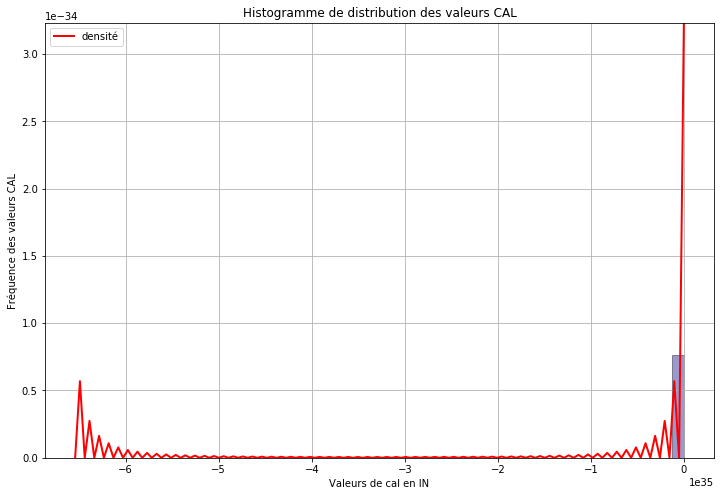

In [67]:
plt.figure(figsize=(12,8))
sns.distplot(data_geox_ml_cal, color = 'darkblue', hist = True, hist_kws={'edgecolor':'black'},kde=True, kde_kws = {'color': 'red', 'lw': 2, 'label':'densité'})
plt.grid()
plt.xlabel('Valeurs de cal en IN')
plt.ylabel('Fréquence des valeurs CAL')
plt.title('Histogramme de distribution des valeurs CAL')

Text(0.5, 1.0, 'Histogramme de distribution des CAL par label')

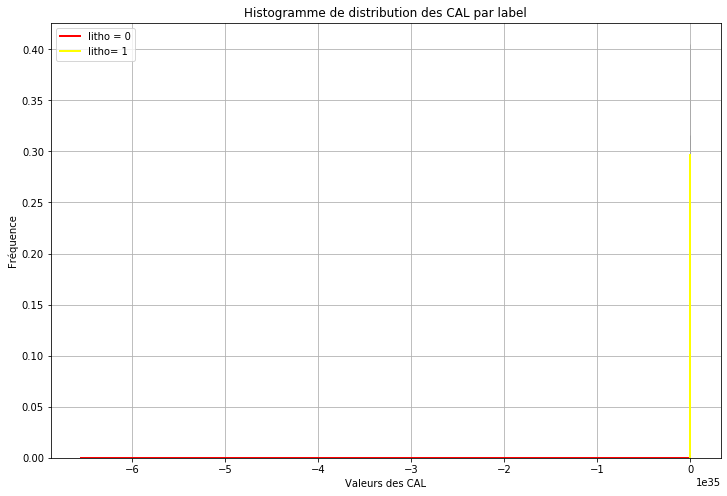

In [68]:
plt.figure(figsize=(12,8))
sns.distplot(data_geox_ml['CAL'].dropna()[data_geox_ml['LITHO'] == 0], color = 'darkblue', hist = True, hist_kws={'edgecolor':'black'},kde=True, kde_kws = {'color': 'red', 'lw': 2, 'label':'litho = 0'})
sns.distplot(data_geox_ml['CAL'].dropna()[data_geox_ml['LITHO'] == 1], color = 'darkblue', hist = True, hist_kws={'edgecolor':'black'},kde=True, kde_kws = {'color': 'yellow', 'lw': 2, 'label':'litho= 1'})
plt.grid()
plt.xlabel('Valeurs des CAL')
plt.ylabel('Fréquence')
plt.title('Histogramme de distribution des CAL par label')

Text(0, 0.5, 'Valeurs du caliper en IN')

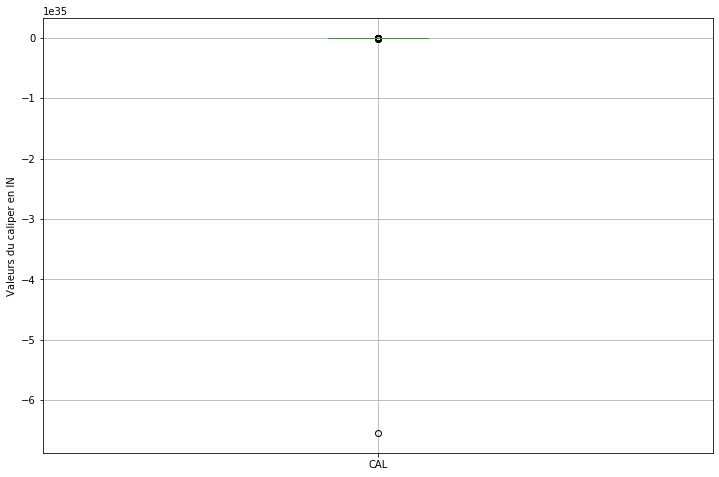

In [69]:
data_geox_ml_cal.plot.box(figsize=(12,8))
plt.grid()
plt.ylabel('Valeurs du caliper en IN')

In [70]:
data_geox_ml[data_geox_ml['CAL'] < 0].head()

,WELL,DEPTH,GR,CAL,DCOR,DENS,DTC,DTS,PE,PHIN,RESD,RESM,RESS,RESMIC,SP,DEPTH_M,LITHO
3182,10/1-A-17,2038.024,35.363800,-5.286180e+08,-0.006,2.01865,117.9,NaN,NaN,0.097417,45.4379,42.6407,NaN,NaN,NaN,2038.024,0
3183,10/1-A-17,2038.176,32.534700,-2.064896e+06,-0.008,2.02700,117.7,NaN,NaN,0.090484,45.2706,42.6266,NaN,NaN,NaN,2038.176,0
3184,10/1-A-17,2038.328,29.907667,-1.385800e+14,NaN,2.04865,117.0,NaN,NaN,0.096194,45.1031,42.6125,NaN,NaN,NaN,2038.328,0
3185,10/1-A-17,2038.480,28.897267,-2.556300e+33,0.002,2.07235,116.2,NaN,NaN,0.112531,44.9357,42.5984,NaN,NaN,NaN,2038.480,0
3186,10/1-A-17,2038.632,28.897267,-2.556300e+33,NaN,2.08300,115.4,NaN,NaN,0.126446,44.7682,42.5843,NaN,NaN,NaN,2038.632,0


In [71]:
data_geox_ml['CAL'][data_geox_ml['CAL'] < 0].count()

344

In [72]:
data_geox_ml['CAL'][data_geox_ml['CAL'] > 30].count()

4

En visualisant ce box plot, on remarque que nous avons **134 valeurs de CAL négatives**.

In [73]:
res_cal_2 = data_geox_ml_cal[(data_geox_ml_cal > 0) & (data_geox_ml_cal < 30) ].describe()
res_cal_2

count    206024.000000
mean         11.814842
std           3.560251
min           0.025000
25%           8.900700
50%          12.240600
75%          13.429700
max          25.827000
Name: CAL, dtype: float64

In [74]:
data_cal = data_geox_ml[['CAL', 'DEPTH_M']].dropna().sort_values(by = 'DEPTH_M')

In [75]:
data_cal.head()

,CAL,DEPTH_M
24872,12.4880,257.4036
24873,12.5070,257.5560
24874,12.5259,257.7084
24875,12.5376,257.8608
24876,12.5443,258.0132


### Remplacer les valeurs négatives par la moyenne

In [76]:
data_cal['CAL'][data_cal['CAL'] < 0] = res_cal_2['mean']

In [77]:
data_cal['CAL'][data_cal['CAL'] > 30] = res_cal_2['mean']

### Tester l'écart de nos données à la moyenne

In [78]:
data_cal['mean_std'] = np.abs(res_cal_2['mean'] - data_cal['CAL'])

In [79]:
data_cal['3_std'] = 3*res_cal_2['std']

In [80]:
data_cal.head()

,CAL,DEPTH_M,mean_std,3_std
24872,12.4880,257.4036,0.673158,10.680752
24873,12.5070,257.5560,0.692158,10.680752
24874,12.5259,257.7084,0.711058,10.680752
24875,12.5376,257.8608,0.722758,10.680752
24876,12.5443,258.0132,0.729458,10.680752


In [81]:
data_cal.shape

(206372, 4)

In [82]:
data_cal[data_cal['mean_std'] > data_cal['3_std']].count()

CAL         5027
DEPTH_M     5027
mean_std    5027
3_std       5027
dtype: int64

### Histogramme après modification

Text(0.5, 1.0, 'Histogramme de distribution des CAL par label')

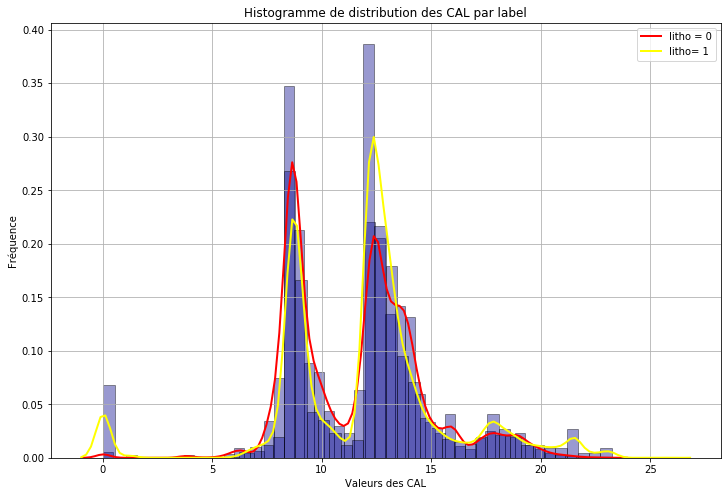

In [83]:
plt.figure(figsize=(12,8))
sns.distplot(data_cal['CAL'].dropna()[data_geox_ml['LITHO'] == 0], color = 'darkblue', hist = True, hist_kws={'edgecolor':'black'},kde=True, kde_kws = {'color': 'red', 'lw': 2, 'label':'litho = 0'})
sns.distplot(data_cal['CAL'].dropna()[data_geox_ml['LITHO'] == 1], color = 'darkblue', hist = True, hist_kws={'edgecolor':'black'},kde=True, kde_kws = {'color': 'yellow', 'lw': 2, 'label':'litho= 1'})
plt.grid()
plt.xlabel('Valeurs des CAL')
plt.ylabel('Fréquence')
plt.title('Histogramme de distribution des CAL par label')

Sur les **136 327** valeurs, on constate que **4014** valeurs ont un écart à la moyenne supérieur à 3 sigma. --> **comment traiter ces valeurs??**

# - DCOR

#### Suppression des données Nan

In [84]:
data_geox_ml_dcor = data_geox_ml['DCOR'].dropna()

In [85]:
res_dcor_1 = data_geox_ml_dcor.describe()
res_dcor_1

count    181615.000000
mean          0.028046
std           0.181640
min         -10.000000
25%           0.001500
50%           0.012000
75%           0.037800
max          10.000000
Name: DCOR, dtype: float64

Text(0.5, 1.0, 'Histogramme de distribution des valeurs DCOR')

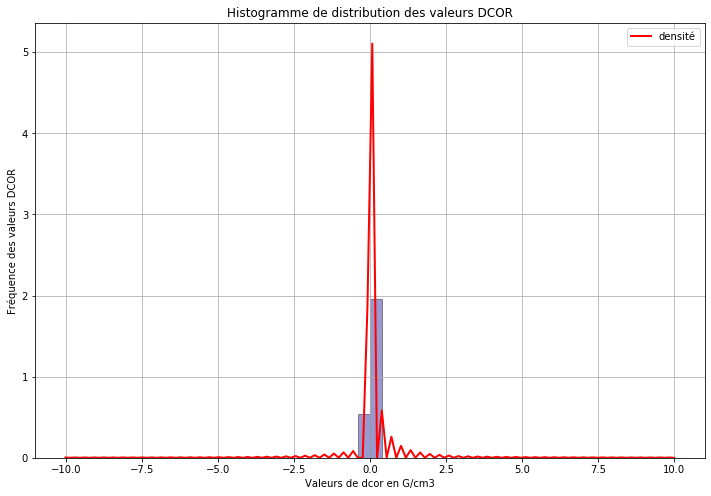

In [86]:
plt.figure(figsize=(12,8))
sns.distplot(data_geox_ml_dcor, color = 'darkblue', hist = True, hist_kws={'edgecolor':'black'},kde=True, kde_kws = {'color': 'red', 'lw': 2, 'label':'densité'})
plt.grid()
plt.xlabel('Valeurs de dcor en G/cm3')
plt.ylabel('Fréquence des valeurs DCOR')
plt.title('Histogramme de distribution des valeurs DCOR')

Text(0.5, 1.0, 'Histogramme de distribution des DCOR par label')

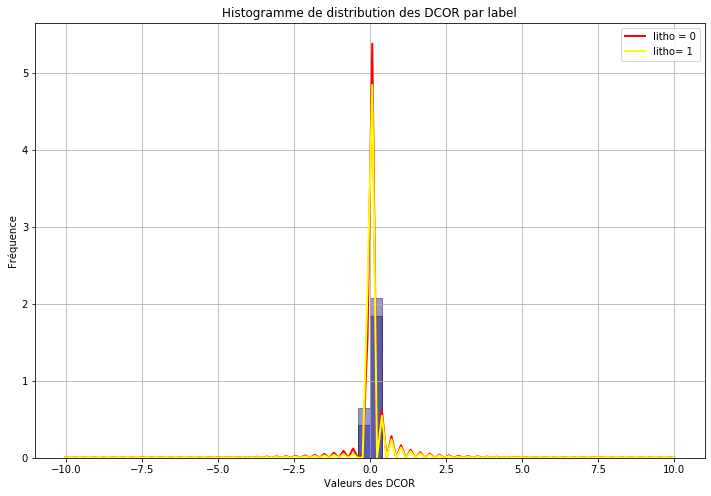

In [87]:
plt.figure(figsize=(12,8))
sns.distplot(data_geox_ml['DCOR'].dropna()[data_geox_ml['LITHO'] == 0], color = 'darkblue', hist = True, hist_kws={'edgecolor':'black'},kde=True, kde_kws = {'color': 'red', 'lw': 2, 'label':'litho = 0'})
sns.distplot(data_geox_ml['DCOR'].dropna()[data_geox_ml['LITHO'] == 1], color = 'darkblue', hist = True, hist_kws={'edgecolor':'black'},kde=True, kde_kws = {'color': 'yellow', 'lw': 2, 'label':'litho= 1'})
plt.grid()
plt.xlabel('Valeurs des DCOR')
plt.ylabel('Fréquence')
plt.title('Histogramme de distribution des DCOR par label')

Text(0, 0.5, 'Valeurs de la densité corrigée en G/cm3')

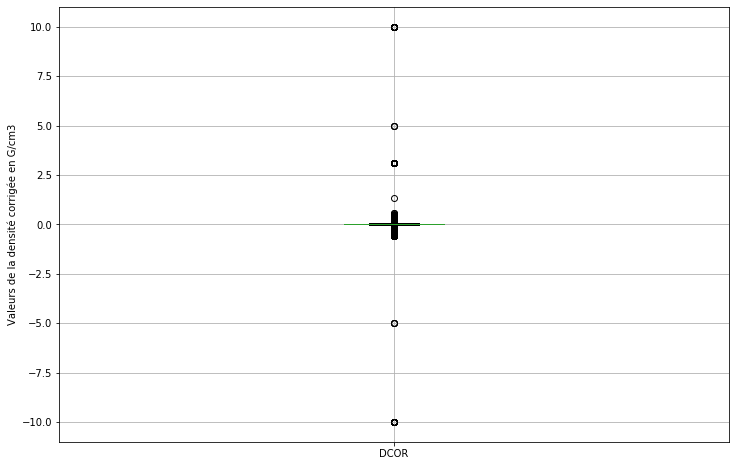

In [88]:
data_geox_ml_dcor.plot.box(figsize=(12,8))
plt.grid()
plt.ylabel('Valeurs de la densité corrigée en G/cm3')

In [89]:
data_geox_ml[data_geox_ml['DCOR'] < 0].head()

,WELL,DEPTH,GR,CAL,DCOR,DENS,DTC,DTS,PE,PHIN,RESD,RESM,RESS,RESMIC,SP,DEPTH_M,LITHO
0,10/1-A-10,2094.872,17.2000,8.48605,-0.275,2.426,72.0,NaN,NaN,0.168400,0.47420,0.19950,NaN,NaN,-22.2857,2094.872,0
1,10/1-A-10,2095.024,18.7058,8.56870,-0.275,2.392,72.0,NaN,NaN,0.182023,0.44160,0.20720,NaN,NaN,-20.0000,2095.024,0
2,10/1-A-10,2095.176,19.3092,8.62140,-0.275,2.378,80.3,NaN,NaN,0.171809,0.23975,0.20720,NaN,NaN,-18.2857,2095.176,0
3,10/1-A-10,2095.328,19.1081,8.71425,-0.275,2.330,75.4,NaN,NaN,0.154246,0.21250,0.19425,NaN,NaN,-16.5714,2095.328,0
4,10/1-A-10,2095.480,20.3536,8.93990,-0.168,2.216,72.1,NaN,NaN,0.141603,0.21080,0.19275,NaN,NaN,-15.1429,2095.480,0


In [90]:
data_geox_ml['DCOR'][data_geox_ml['DCOR'] < 0].count()

39321

In [91]:
data_geox_ml['DCOR'][data_geox_ml['DCOR'] > 2.5].count()

198

En visualisant le box plot de **DCOR**, nous notons **27774 valeurs négatives** et **21 valeurs supérieures à 2.5**

In [92]:
res_dcor_2 = data_geox_ml_dcor[(data_geox_ml_dcor > 0 ) & (data_geox_ml_dcor < 2.5)].describe()
res_dcor_2

count    142093.000000
mean          0.036426
std           0.043954
min           0.000032
25%           0.008000
50%           0.019800
75%           0.048099
max           1.313000
Name: DCOR, dtype: float64

In [93]:
data_dcor = data_geox_ml[['DCOR', 'DEPTH_M']].dropna().sort_values(by = 'DEPTH_M')

In [94]:
data_dcor.head()

,DCOR,DEPTH_M
373504,0.0131,310.017444
96863,0.0131,310.017444
96864,0.0124,310.063896
373505,0.0124,310.063896
96865,0.0115,310.110348


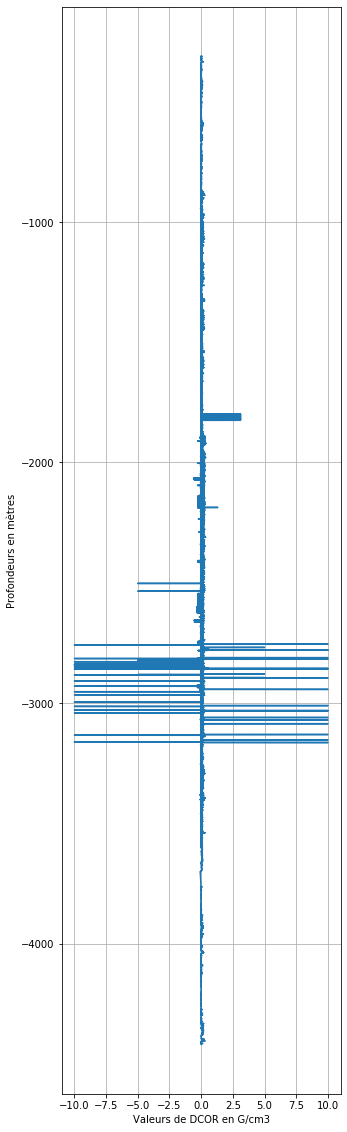

In [95]:
plt.figure(figsize=(5,20))
plt.plot(data_dcor['DCOR'], data_dcor['DEPTH_M']*-1)
plt.xlabel('Valeurs de DCOR en G/cm3')
plt.ylabel('Profondeurs en mètres')
plt.grid()

### Remplacer les valeurs DCOR négatives et supérieures à 2.5 par la moyenne

In [96]:
#data_dcor['DCOR'][(data_dcor['DCOR'] < 0) | (data_dcor['DCOR'] > 2.5)] = res_dcor_2['mean']

### Tester l'écart de nos données à la moyenne

In [97]:
#data_dcor['mean_std'] = np.abs(res_dcor_2['mean'] - data_dcor['DCOR'])
#data_dcor['3_std'] = 3*res_dcor_2['std']

In [98]:
#data_dcor.head()

In [99]:
#data_dcor.shape

In [100]:
#data_dcor[data_dcor['mean_std'] > data_dcor['3_std']].count()

**1499** valeurs sur les **122176** sont supérieures à  3 sigma

In [101]:
"""plt.figure(figsize=(5,20))
plt.plot(data_dcor['DCOR'], data_dcor['DEPTH_M']*-1)
plt.xlabel('Valeurs de DCOR en G/cm3')
plt.ylabel('Profondeurs en mètres')
plt.grid()"""

"plt.figure(figsize=(5,20))\nplt.plot(data_dcor['DCOR'], data_dcor['DEPTH_M']*-1)\nplt.xlabel('Valeurs de DCOR en G/cm3')\nplt.ylabel('Profondeurs en mètres')\nplt.grid()"

# - DENS

#### Suppression des données Nan

In [102]:
data_geox_ml_dens = data_geox_ml['DENS'].dropna()

In [103]:
res_dens_1 = data_geox_ml_dens.describe()
res_dens_1

count    1.910600e+05
mean    -1.424422e+23
std      6.226206e+25
min     -2.721500e+28
25%      2.362500e+00
50%      2.446500e+00
75%      2.539600e+00
max      1.568000e+03
Name: DENS, dtype: float64

Text(0.5, 1.0, 'Histogramme de distribution des valeurs DENS')

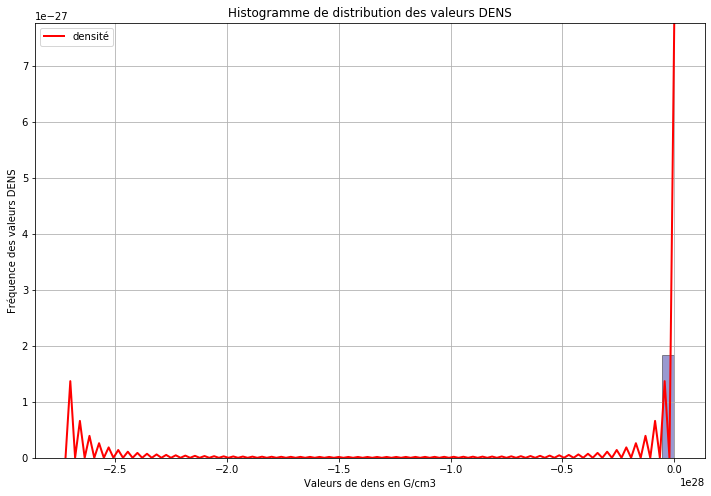

In [104]:
plt.figure(figsize=(12,8))
sns.distplot(data_geox_ml_dens, color = 'darkblue', hist = True, hist_kws={'edgecolor':'black'},kde=True, kde_kws = {'color': 'red', 'lw': 2, 'label':'densité'})
plt.grid()
plt.xlabel('Valeurs de dens en G/cm3')
plt.ylabel('Fréquence des valeurs DENS')
plt.title('Histogramme de distribution des valeurs DENS')

Text(0.5, 1.0, 'Histogramme de distribution des DENS par label')

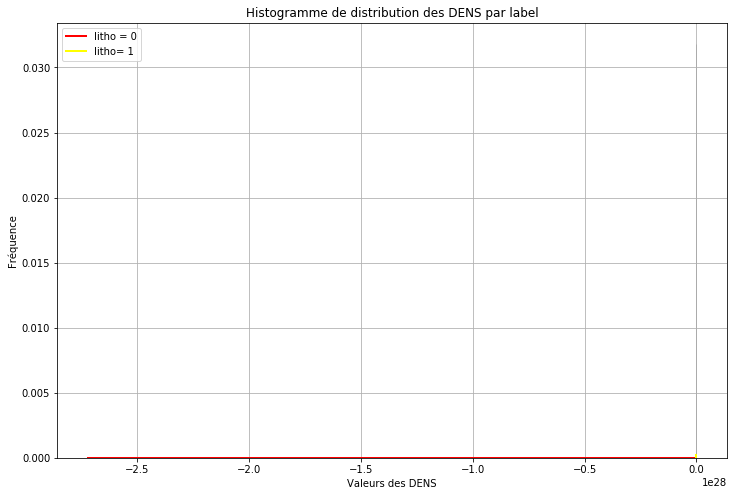

In [105]:
plt.figure(figsize=(12,8))
sns.distplot(data_geox_ml['DENS'].dropna()[data_geox_ml['LITHO'] == 0], color = 'darkblue', hist = True, hist_kws={'edgecolor':'black'},kde=True, kde_kws = {'color': 'red', 'lw': 2, 'label':'litho = 0'})
sns.distplot(data_geox_ml['DENS'].dropna()[data_geox_ml['LITHO'] == 1], color = 'darkblue', hist = True, hist_kws={'edgecolor':'black'},kde=True, kde_kws = {'color': 'yellow', 'lw': 2, 'label':'litho= 1'})
plt.grid()
plt.xlabel('Valeurs des DENS')
plt.ylabel('Fréquence')
plt.title('Histogramme de distribution des DENS par label')

Text(0, 0.5, 'Valeurs de la densité en G/cm3')

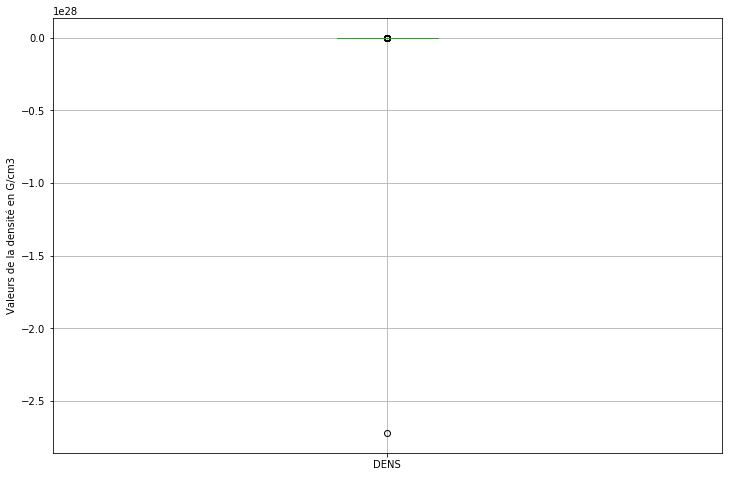

In [106]:
data_geox_ml_dens.plot.box(figsize=(12,8))
plt.grid()
plt.ylabel('Valeurs de la densité en G/cm3')

In [107]:
data_geox_ml['DENS'][data_geox_ml['DENS'] < 0].count()

1

In [108]:
data_geox_ml['DENS'][data_geox_ml['DENS'] > 2.90].count()

425

In [109]:
res_dens_2 = data_geox_ml_dens[(data_geox_ml_dens > 0 ) & (data_geox_ml_dens < 2.90)].describe()
res_dens_2

count    190634.000000
mean          2.429712
std           0.182483
min           0.035800
25%           2.362300
50%           2.446100
75%           2.539100
max           2.899700
Name: DENS, dtype: float64

En visualisant le box plot de **DENS**, on remarque que nous avons 1 valeur négative et **418 valeurs supérieures à 2.90**

In [110]:
data_dens = data_geox_ml[['DENS', 'DEPTH_M']].dropna().sort_values(by = 'DEPTH_M')

In [111]:
data_dens.head()

,DENS,DEPTH_M
373504,2.2986,310.017444
96863,2.2986,310.017444
96864,2.2932,310.063896
373505,2.2932,310.063896
373506,2.2949,310.110348


In [112]:
data_dens['DENS'][data_dens['DENS'] < 0] = res_dens_2['mean']
data_dens['DENS'][data_dens['DENS'] > 2.90] = res_dens_2['mean']

### Tester l'écart de nos données à la moyenne

In [113]:
data_dens['mean_std'] = np.abs(res_dens_2['mean'] - data_dens['DENS'])
data_dens['3_std'] = 3*res_dens_2['std']

In [114]:
data_dens.head()

,DENS,DEPTH_M,mean_std,3_std
373504,2.2986,310.017444,0.131112,0.547449
96863,2.2986,310.017444,0.131112,0.547449
96864,2.2932,310.063896,0.136512,0.547449
373505,2.2932,310.063896,0.136512,0.547449
373506,2.2949,310.110348,0.134812,0.547449


In [115]:
data_dens.shape

(191060, 4)

In [116]:
data_dens[data_dens['mean_std'] > data_dens['3_std']].count()

DENS        1744
DEPTH_M     1744
mean_std    1744
3_std       1744
dtype: int64

on a 1090 valeurs supérieures à 3 sigma

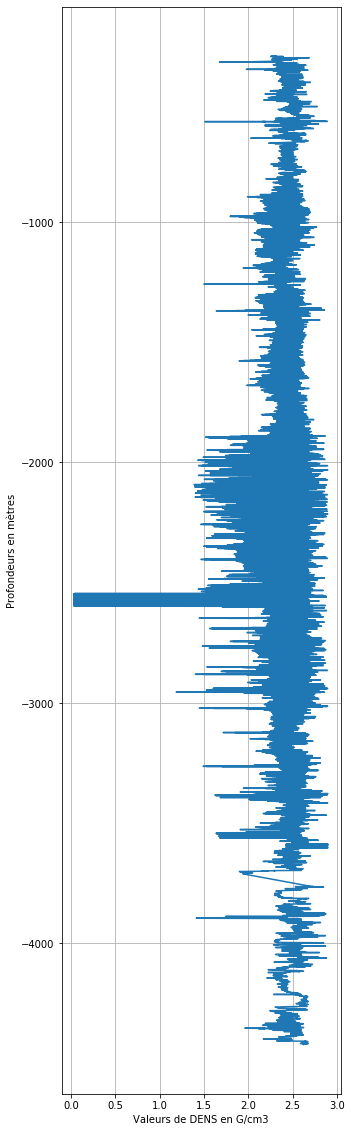

In [117]:
plt.figure(figsize=(5,20))
plt.plot(data_dens['DENS'], data_dens['DEPTH_M']*-1)
plt.xlabel('Valeurs de DENS en G/cm3')
plt.ylabel('Profondeurs en mètres')
plt.grid()

**Voir comment traiter les valeurs à 0 et celles supérieures à 3 sigma!!***

### Histogramme après modification

Text(0.5, 1.0, 'Histogramme de distribution des DENS par label')

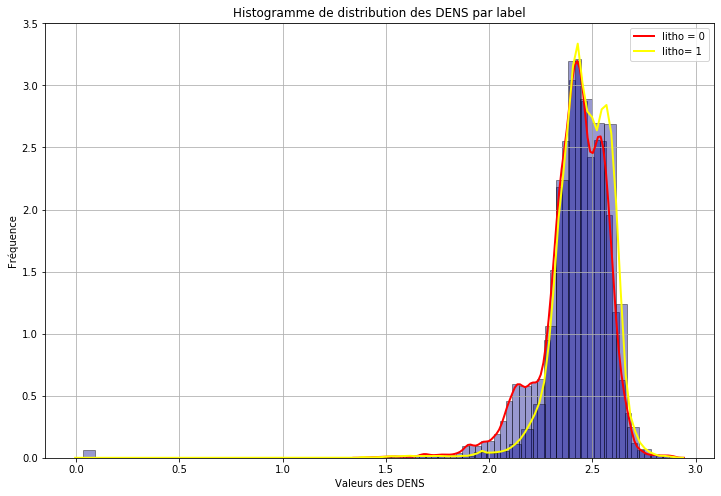

In [118]:
plt.figure(figsize=(12,8))
sns.distplot(data_dens['DENS'].dropna()[data_geox_ml['LITHO'] == 0], color = 'darkblue', hist = True, hist_kws={'edgecolor':'black'},kde=True, kde_kws = {'color': 'red', 'lw': 2, 'label':'litho = 0'})
sns.distplot(data_dens['DENS'].dropna()[data_geox_ml['LITHO'] == 1], color = 'darkblue', hist = True, hist_kws={'edgecolor':'black'},kde=True, kde_kws = {'color': 'yellow', 'lw': 2, 'label':'litho= 1'})
plt.grid()
plt.xlabel('Valeurs des DENS')
plt.ylabel('Fréquence')
plt.title('Histogramme de distribution des DENS par label')

# - DTC

### Suppression des données Nan

In [119]:
data_geox_ml_dtc = data_geox_ml['DTC'].dropna()

In [120]:
res_dtc_1 = data_geox_ml_dtc.describe()
res_dtc_1

count    332076.000000
mean         92.710620
std          21.229455
min        -152.500000
25%          76.990500
50%          92.560900
75%         103.187500
max        1269.000000
Name: DTC, dtype: float64

Text(0.5, 1.0, 'Histogramme de distribution des valeurs DTCC')

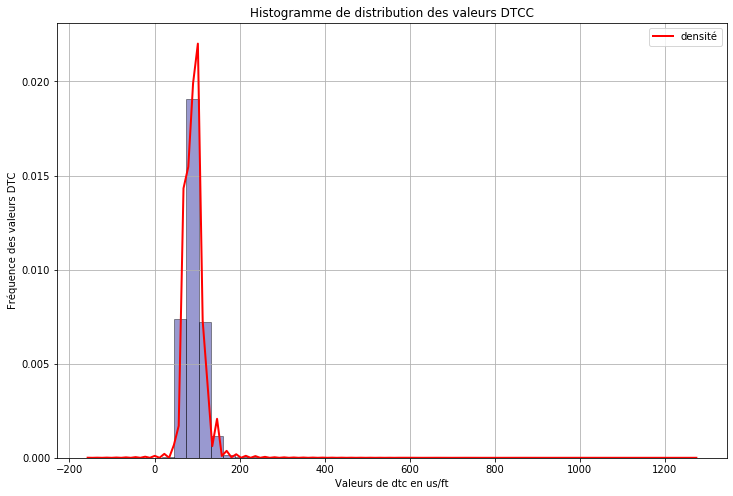

In [121]:
plt.figure(figsize=(12,8))
sns.distplot(data_geox_ml_dtc, color = 'darkblue', hist = True, hist_kws={'edgecolor':'black'},kde=True, kde_kws = {'color': 'red', 'lw': 2, 'label':'densité'})
plt.grid()
plt.xlabel('Valeurs de dtc en us/ft')
plt.ylabel('Fréquence des valeurs DTC')
plt.title('Histogramme de distribution des valeurs DTCC')

Text(0.5, 1.0, 'Histogramme de distribution des DTC par label')

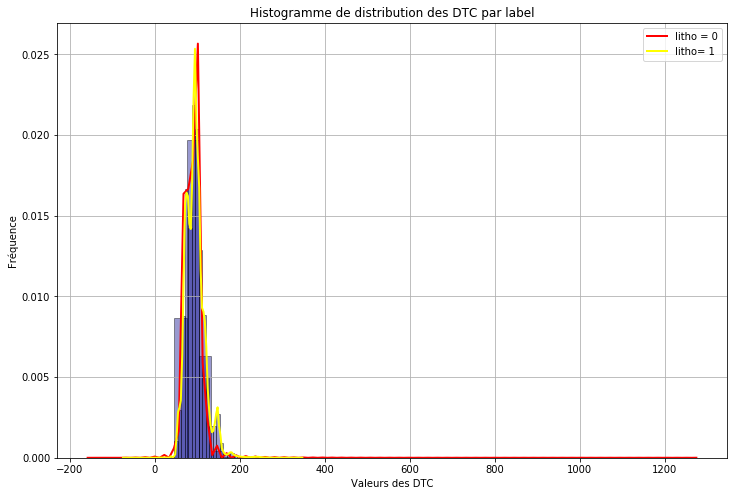

In [122]:
plt.figure(figsize=(12,8))
sns.distplot(data_geox_ml['DTC'].dropna()[data_geox_ml['LITHO'] == 0], color = 'darkblue', hist = True, hist_kws={'edgecolor':'black'},kde=True, kde_kws = {'color': 'red', 'lw': 2, 'label':'litho = 0'})
sns.distplot(data_geox_ml['DTC'].dropna()[data_geox_ml['LITHO'] == 1], color = 'darkblue', hist = True, hist_kws={'edgecolor':'black'},kde=True, kde_kws = {'color': 'yellow', 'lw': 2, 'label':'litho= 1'})
plt.grid()
plt.xlabel('Valeurs des DTC')
plt.ylabel('Fréquence')
plt.title('Histogramme de distribution des DTC par label')

Text(0, 0.5, 'Valeurs de la DTC en us/ft')

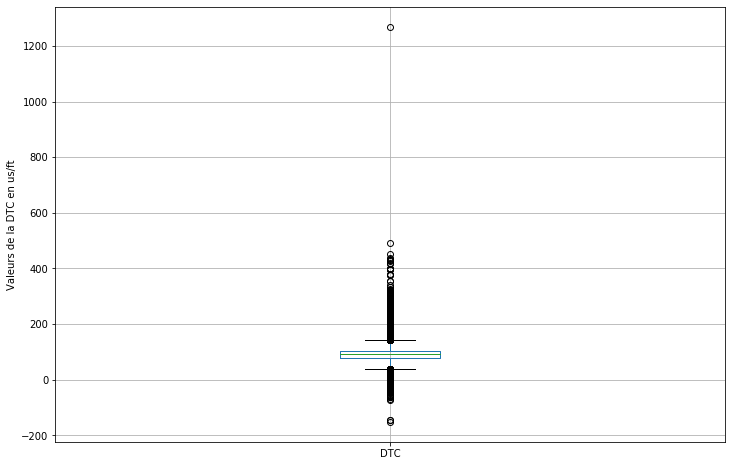

In [123]:
data_geox_ml_dtc.plot.box(figsize=(12,8))
plt.grid()
plt.ylabel('Valeurs de la DTC en us/ft')

In [124]:
data_geox_ml['DTC'][data_geox_ml['DTC'] < 0].count()

61

In [125]:
data_geox_ml[data_geox_ml['DTC'] < 0].head()

,WELL,DEPTH,GR,CAL,DCOR,DENS,DTC,DTS,PE,PHIN,RESD,RESM,RESS,RESMIC,SP,DEPTH_M,LITHO
137001,11/30A-A12,3741.0,31.5938,NaN,NaN,NaN,-6.6016,NaN,NaN,NaN,9.3516,49.8125,NaN,NaN,34.4688,1140.2568,1
137350,11/30A-A12,3915.5,74.5625,NaN,NaN,NaN,-45.2188,NaN,NaN,NaN,8.6484,6.9531,NaN,NaN,54.0000,1193.4444,1
137351,11/30A-A12,3916.0,69.1250,NaN,NaN,NaN,-49.8125,NaN,NaN,NaN,9.7109,7.6758,NaN,NaN,53.2188,1193.5968,1
137354,11/30A-A12,3917.5,60.0938,NaN,NaN,NaN,-69.2500,NaN,NaN,NaN,9.9922,9.6172,NaN,NaN,52.7188,1194.0540,1
137355,11/30A-A12,3918.0,54.4375,NaN,NaN,NaN,-30.0000,NaN,NaN,NaN,9.1719,10.9453,NaN,NaN,53.7188,1194.2064,1


In [126]:
data_geox_ml['DTC'][data_geox_ml['DTC'] > 500].count()

1

In [127]:
data_geox_ml[data_geox_ml['DTC'] > 500].head()

,WELL,DEPTH,GR,CAL,DCOR,DENS,DTC,DTS,PE,PHIN,RESD,RESM,RESS,RESMIC,SP,DEPTH_M,LITHO
201672,11/30A-A26Z,8241.5,75.5625,13.422,0.0573,2.3588,1269.0,NaN,5.7829,0.4534,4.8647,5.7212,NaN,NaN,135.125,2512.0092,0


En analysant le boxplot ci-dessus, on remarque que nous avons:
- **61 valeurs négatives**
- **1 valeur supérieure à 1200 us/ft**

En observant de façon plus précise les fichiers concernés, on constate que les valeurs négatives sont très  localisées et s'expliquent peut-être par le changement du type de lithologie.

Pour la vitesse supérieure à 1200 us/ft, il s'agit simplement d'une valeur aberrante car les données entourant cette valeur sont entre 40 et 100 us/ft

In [128]:
data_dtc = data_geox_ml[['DTC', 'DEPTH_M']].dropna().sort_values(by = 'DEPTH_M')

In [129]:
data_dtc.head()

,DTC,DEPTH_M
67743,204.45,131.0640
67744,204.75,131.2164
67745,204.75,131.3688
67746,204.75,131.5212
67747,203.80,131.6736


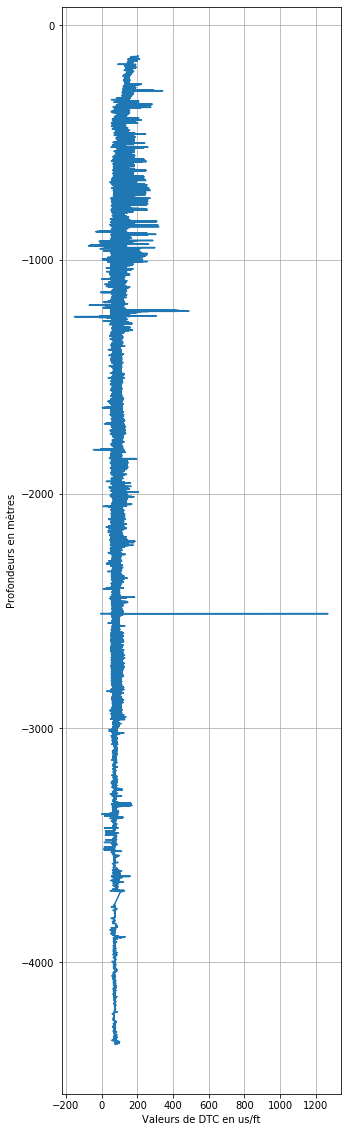

In [130]:
plt.figure(figsize=(5,20))
plt.plot(data_dtc['DTC'], data_dtc['DEPTH_M']*-1)
plt.xlabel('Valeurs de DTC en us/ft')
plt.ylabel('Profondeurs en mètres')
plt.grid()

### Remplacement des valeurs aberrantes (négatives et supérieures à 500 us/ft)

In [131]:
res_dtc_2 = data_geox_ml_dtc[(data_geox_ml_dtc > 0 ) & (data_geox_ml_dtc < 500)].describe()
res_dtc_2

count    332014.000000
mean         92.730131
std          21.059794
min           0.199700
25%          76.999675
50%          92.562500
75%         103.187500
max         489.874300
Name: DTC, dtype: float64

In [132]:
data_dtc['DTC'][(data_geox_ml_dtc < 0 ) | (data_geox_ml_dtc > 500)] = res_dtc_2['mean']

### Tester l'écart de nos données à la moyenne

In [133]:
data_dtc['mean_std'] = np.abs(res_dtc_2['mean'] - data_dtc['DTC'])
data_dtc['3_std'] = 3*res_dtc_2['std']

In [134]:
data_dtc.head()

,DTC,DEPTH_M,mean_std,3_std
67743,204.45,131.0640,111.719869,63.179381
67744,204.75,131.2164,112.019869,63.179381
67745,204.75,131.3688,112.019869,63.179381
67746,204.75,131.5212,112.019869,63.179381
67747,203.80,131.6736,111.069869,63.179381


In [135]:
data_dtc.shape

(332076, 4)

In [136]:
data_dtc[data_dtc['mean_std'] > data_dtc['3_std']].count()

DTC         3136
DEPTH_M     3136
mean_std    3136
3_std       3136
dtype: int64

**2924 valeurs** sur **165244 valeurs** sont supérieures à 3 sigma.

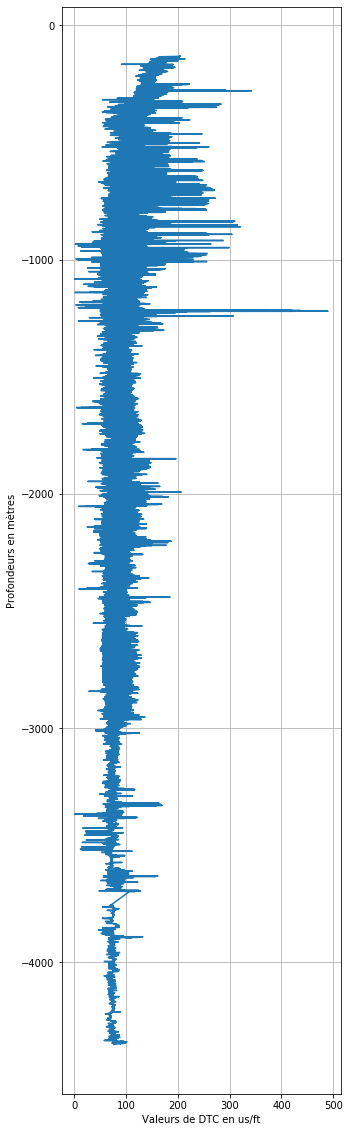

In [137]:
plt.figure(figsize=(5,20))
plt.plot(data_dtc['DTC'], data_dtc['DEPTH_M']*-1)
plt.xlabel('Valeurs de DTC en us/ft')
plt.ylabel('Profondeurs en mètres')
plt.grid()

### Histogramme après modification

Text(0.5, 1.0, 'Histogramme de distribution des DTC par label')

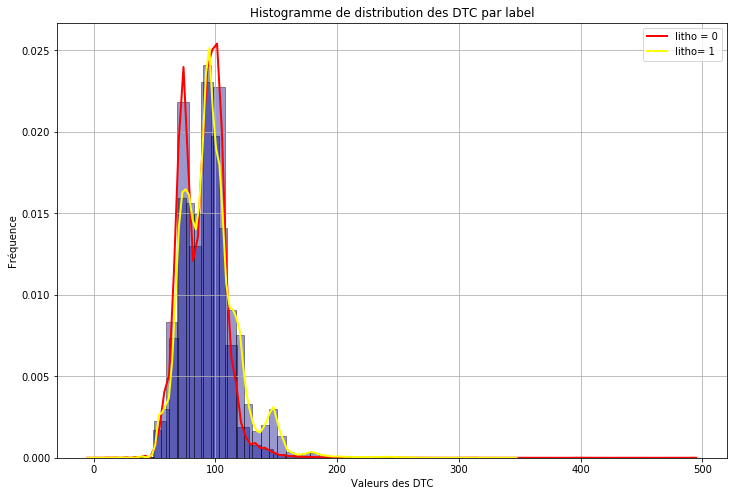

In [138]:
plt.figure(figsize=(12,8))
sns.distplot(data_dtc['DTC'].dropna()[data_geox_ml['LITHO'] == 0], color = 'darkblue', hist = True, hist_kws={'edgecolor':'black'},kde=True, kde_kws = {'color': 'red', 'lw': 2, 'label':'litho = 0'})
sns.distplot(data_dtc['DTC'].dropna()[data_geox_ml['LITHO'] == 1], color = 'darkblue', hist = True, hist_kws={'edgecolor':'black'},kde=True, kde_kws = {'color': 'yellow', 'lw': 2, 'label':'litho= 1'})
plt.grid()
plt.xlabel('Valeurs des DTC')
plt.ylabel('Fréquence')
plt.title('Histogramme de distribution des DTC par label')

# - PE

### Suppression des valeurs Nan

In [139]:
data_geox_ml_pe = data_geox_ml['PE'].dropna()

In [140]:
res_pe_1 = data_geox_ml_pe.describe()
res_pe_1

count    56526.000000
mean         4.074136
std          2.058914
min          0.860600
25%          3.032825
50%          3.642250
75%          4.722800
max         55.368800
Name: PE, dtype: float64

Text(0.5, 1.0, 'Histogramme de distribution des valeurs PE')

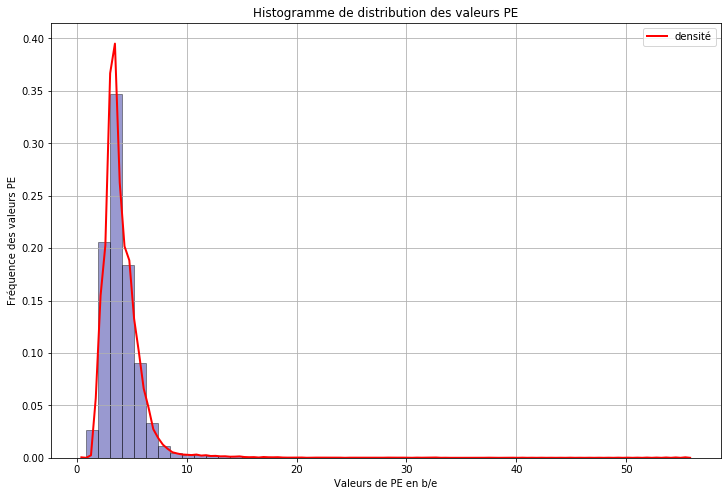

In [141]:
plt.figure(figsize=(12,8))
sns.distplot(data_geox_ml_pe, color = 'darkblue', hist = True, hist_kws={'edgecolor':'black'},kde=True, kde_kws = {'color': 'red', 'lw': 2, 'label':'densité'})
plt.grid()
plt.xlabel('Valeurs de PE en b/e')
plt.ylabel('Fréquence des valeurs PE')
plt.title('Histogramme de distribution des valeurs PE')

Text(0.5, 1.0, 'Histogramme de distribution des PE par label')

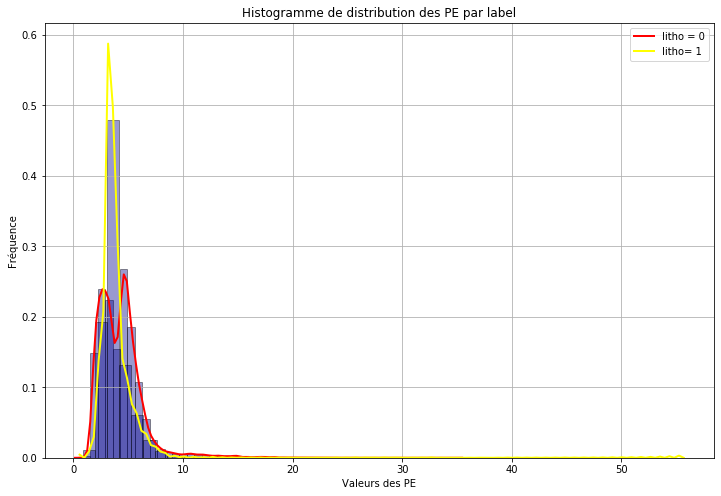

In [142]:
plt.figure(figsize=(12,8))
sns.distplot(data_geox_ml['PE'].dropna()[data_geox_ml['LITHO'] == 0], color = 'darkblue', hist = True, hist_kws={'edgecolor':'black'},kde=True, kde_kws = {'color': 'red', 'lw': 2, 'label':'litho = 0'})
sns.distplot(data_geox_ml['PE'].dropna()[data_geox_ml['LITHO'] == 1], color = 'darkblue', hist = True, hist_kws={'edgecolor':'black'},kde=True, kde_kws = {'color': 'yellow', 'lw': 2, 'label':'litho= 1'})
plt.grid()
plt.xlabel('Valeurs des PE')
plt.ylabel('Fréquence')
plt.title('Histogramme de distribution des PE par label')

Text(0, 0.5, 'Valeurs du PE en b/e')

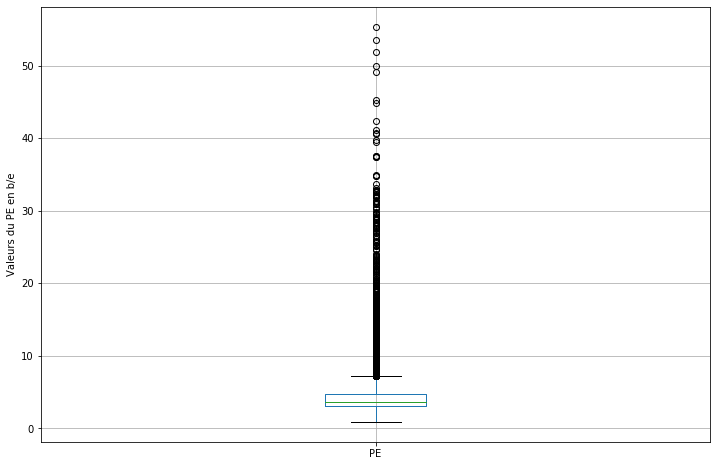

In [143]:
data_geox_ml_pe.plot.box(figsize=(12,8))
plt.grid()
plt.ylabel('Valeurs du PE en b/e')

In [144]:
data_geox_ml['PE'][data_geox_ml['PE'] > 50].count()

3

In [145]:
data_geox_ml[data_geox_ml['PE'] > 50].head()

,WELL,DEPTH,GR,CAL,DCOR,DENS,DTC,DTS,PE,PHIN,RESD,RESM,RESS,RESMIC,SP,DEPTH_M,LITHO
211578,11/30A-A29,12141.5,81.1250,NaN,-0.0804,1.9075,NaN,NaN,53.4813,0.2725,4.5046,4.8994,NaN,NaN,307.75,3700.7292,1
211593,11/30A-A29,12149.0,77.6875,NaN,-0.0802,1.9241,NaN,NaN,55.3688,0.2240,6.5466,7.1809,NaN,NaN,349.50,3703.0152,1
211594,11/30A-A29,12149.5,81.5625,NaN,-0.0802,1.9268,NaN,NaN,51.8688,0.2256,6.6493,7.2383,NaN,NaN,355.50,3703.1676,1


En observant le box plot des valeurs de PE, aucune valeur ne nous semble aberrante. 

In [146]:
data_pe = data_geox_ml[['PE', 'DEPTH_M']].dropna().sort_values(by = 'DEPTH_M')

In [147]:
data_pe.head()

,PE,DEPTH_M
368286,3.4554,1248.9180
368287,3.4188,1249.0704
368288,3.1270,1249.2228
368289,2.9691,1249.3752
368290,2.8895,1249.5276


In [148]:
data_pe['mean_std'] = res_pe_1['mean'] - data_pe['PE'] 

In [149]:
data_pe['3_std'] = 3 * res_pe_1['std']

In [150]:
data_pe[data_pe['mean_std'] > data_pe['3_std']].count()

PE          0
DEPTH_M     0
mean_std    0
3_std       0
dtype: int64

**Aucune donnée ne possède un écart à la moyenne supérieure à 3 fois l'écart-type**

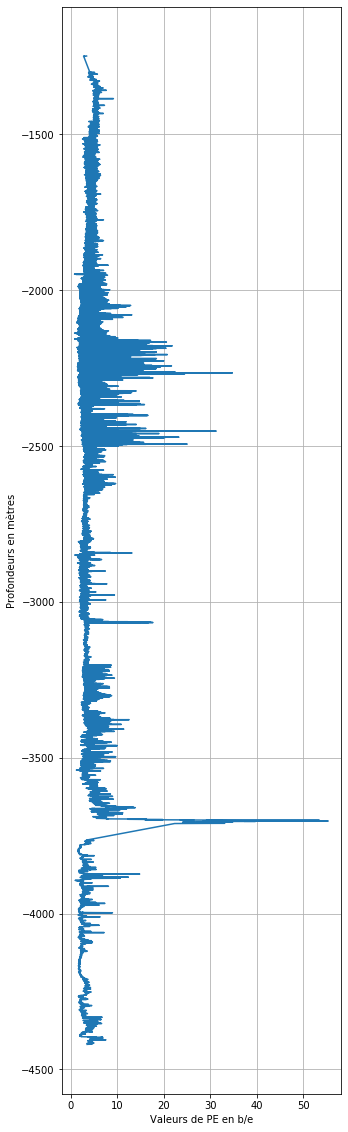

In [151]:
plt.figure(figsize=(5,20))
plt.plot(data_pe['PE'], data_pe['DEPTH_M']*-1)
plt.xlabel('Valeurs de PE en b/e')
plt.ylabel('Profondeurs en mètres')
plt.grid()

# PHIN

In [152]:
data_geox_ml_phin = data_geox_ml['PHIN'].dropna()

In [153]:
res_phin_1 = data_geox_ml_phin.describe()
res_phin_1

count    205230.000000
mean          0.293084
std           2.075838
min          -5.967900
25%           0.130390
50%           0.226725
75%           0.330324
max          70.437500
Name: PHIN, dtype: float64

Text(0.5, 1.0, 'Histogramme de distribution des valeurs PHIN')

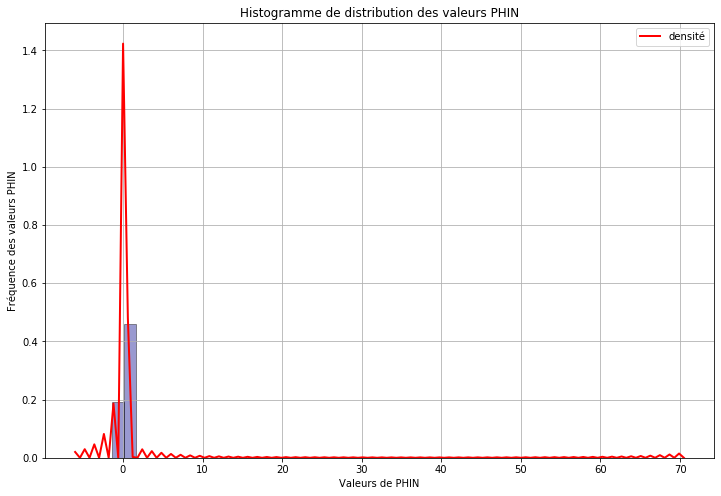

In [154]:
plt.figure(figsize=(12,8))
sns.distplot(data_geox_ml_phin, color = 'darkblue', hist = True, hist_kws={'edgecolor':'black'},kde=True, kde_kws = {'color': 'red', 'lw': 2, 'label':'densité'})
plt.grid()
plt.xlabel('Valeurs de PHIN')
plt.ylabel('Fréquence des valeurs PHIN')
plt.title('Histogramme de distribution des valeurs PHIN')

Text(0.5, 1.0, 'Histogramme de distribution des PHIN par label')

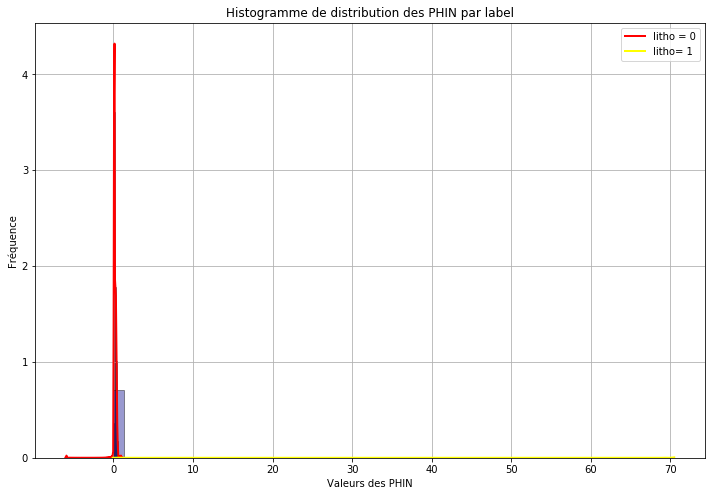

In [155]:
plt.figure(figsize=(12,8))
sns.distplot(data_geox_ml['PHIN'].dropna()[data_geox_ml['LITHO'] == 0], color = 'darkblue', hist = True, hist_kws={'edgecolor':'black'},kde=True, kde_kws = {'color': 'red', 'lw': 2, 'label':'litho = 0'})
sns.distplot(data_geox_ml['PHIN'].dropna()[data_geox_ml['LITHO'] == 1], color = 'darkblue', hist = True, hist_kws={'edgecolor':'black'},kde=True, kde_kws = {'color': 'yellow', 'lw': 2, 'label':'litho= 1'})
plt.grid()
plt.xlabel('Valeurs des PHIN')
plt.ylabel('Fréquence')
plt.title('Histogramme de distribution des PHIN par label')

Text(0, 0.5, 'Valeurs du PHIN')

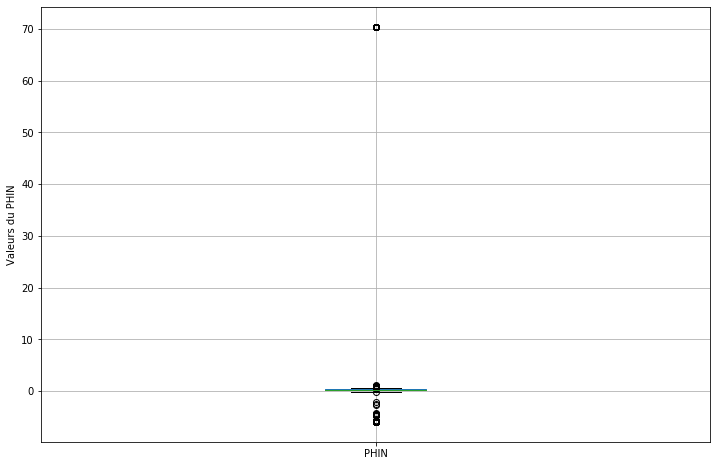

In [156]:
data_geox_ml_phin.plot.box(figsize=(12,8))
plt.grid()
plt.ylabel('Valeurs du PHIN')

In [157]:
data_geox_ml['PHIN'][data_geox_ml['PHIN'] > 1].count()

178

In [158]:
data_geox_ml['PHIN'][data_geox_ml['PHIN'] < -0.15].count()

240

En observant la boxplot, on constate que nous avons **238 données** dont la porosité est inférieure à **-0.15**

In [159]:
data_phin = data_geox_ml[['PHIN', 'DEPTH_M']].dropna().sort_values(by = 'DEPTH_M')
data_phin.head()

,PHIN,DEPTH_M
404569,0.563905,198.2724
404570,0.561797,198.4248
404571,0.554885,198.5772
404572,0.521537,198.7296
404573,0.540630,198.8820


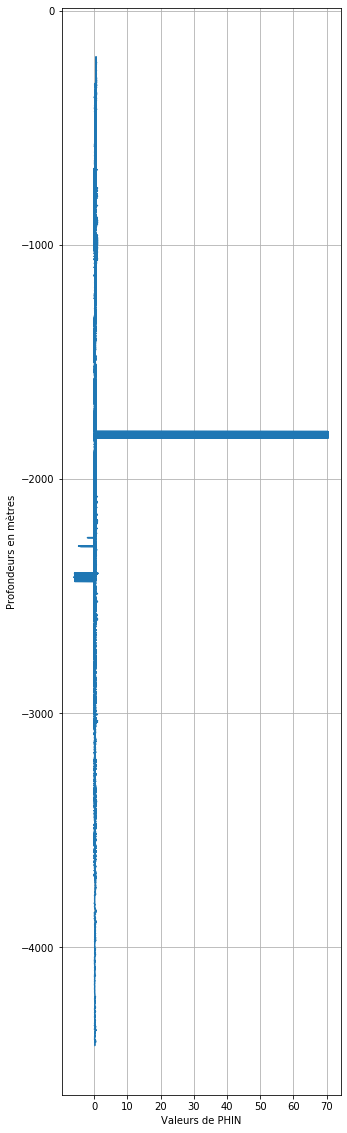

In [160]:
plt.figure(figsize=(5,20))
plt.plot(data_phin['PHIN'], data_phin['DEPTH_M']*-1)
plt.xlabel('Valeurs de PHIN')
plt.ylabel('Profondeurs en mètres')
plt.grid()

### Remplacer les valeurs inférieures à **-0.15** et supérieures à **1** par la moyenne

In [161]:
res_phin_2 = data_geox_ml_phin[(data_geox_ml_phin > -0.20 ) & (data_geox_ml_phin < 1 )].describe()
res_phin_2

count    204814.000000
mean          0.239518
std           0.140658
min          -0.171600
25%           0.130600
50%           0.226800
75%           0.330200
max           0.999400
Name: PHIN, dtype: float64

In [162]:
data_phin['PHIN'][(data_geox_ml_phin < -0.20 )] = res_phin_2['mean']

In [163]:
data_phin['PHIN'][(data_geox_ml_phin > 1 )] = res_phin_2['mean']

In [164]:
data_phin['mean_std'] = res_phin_2['mean'] - data_phin['PHIN'] 
data_phin['3_std'] = 3 * res_phin_2['std']

In [165]:
data_phin[data_phin['mean_std'] > data_phin['3_std']].count()

PHIN        0
DEPTH_M     0
mean_std    0
3_std       0
dtype: int64

Aucune valeur supérieure à 3 sigma

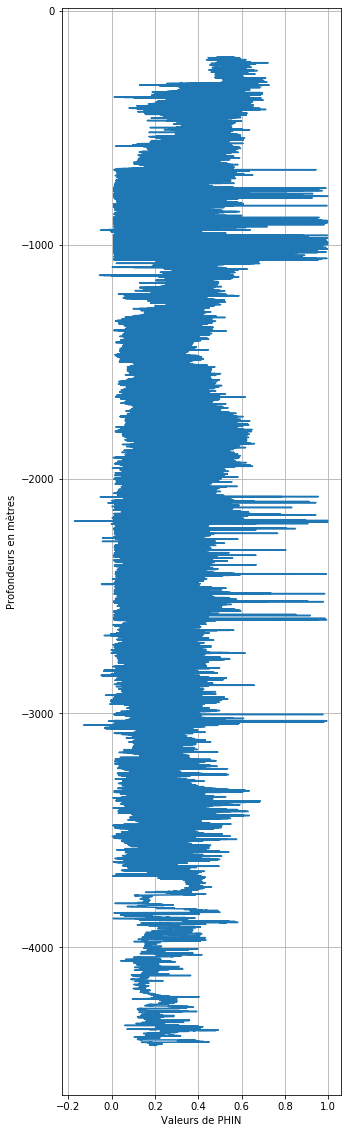

In [166]:
plt.figure(figsize=(5,20))
plt.plot(data_phin['PHIN'], data_phin['DEPTH_M']*-1)
plt.xlabel('Valeurs de PHIN')
plt.ylabel('Profondeurs en mètres')
plt.grid()

Text(0.5, 1.0, 'Histogramme de distribution des PHIN par label')

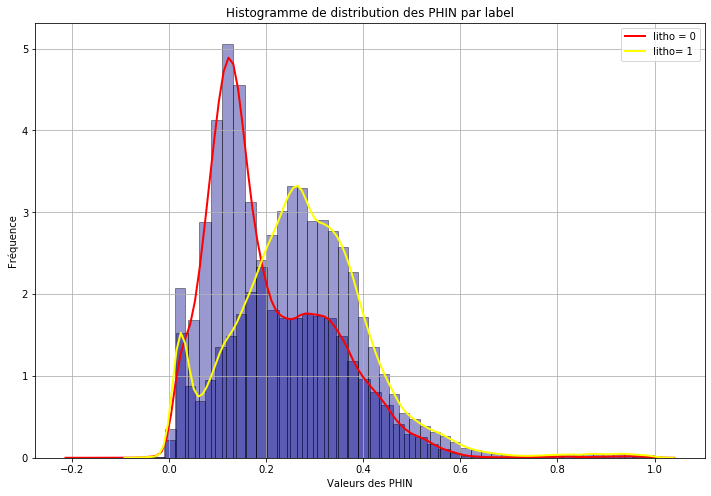

In [167]:
plt.figure(figsize=(12,8))
sns.distplot(data_phin['PHIN'].dropna()[data_geox_ml['LITHO'] == 0], color = 'darkblue', hist = True, hist_kws={'edgecolor':'black'},kde=True, kde_kws = {'color': 'red', 'lw': 2, 'label':'litho = 0'})
sns.distplot(data_phin['PHIN'].dropna()[data_geox_ml['LITHO'] == 1], color = 'darkblue', hist = True, hist_kws={'edgecolor':'black'},kde=True, kde_kws = {'color': 'yellow', 'lw': 2, 'label':'litho= 1'})
plt.grid()
plt.xlabel('Valeurs des PHIN')
plt.ylabel('Fréquence')
plt.title('Histogramme de distribution des PHIN par label')

# RESD

In [168]:
data_geox_ml_resd = data_geox_ml['RESD'].dropna()

In [169]:
res_resd_1 = data_geox_ml_resd.describe()
res_resd_1

count    262608.000000
mean        176.765664
std        4275.676336
min           0.062800
25%           4.079300
50%           6.308000
75%           9.274725
max      173255.093800
Name: RESD, dtype: float64

Text(0.5, 1.0, 'Histogramme de distribution des valeurs logarithmiques de RESD')

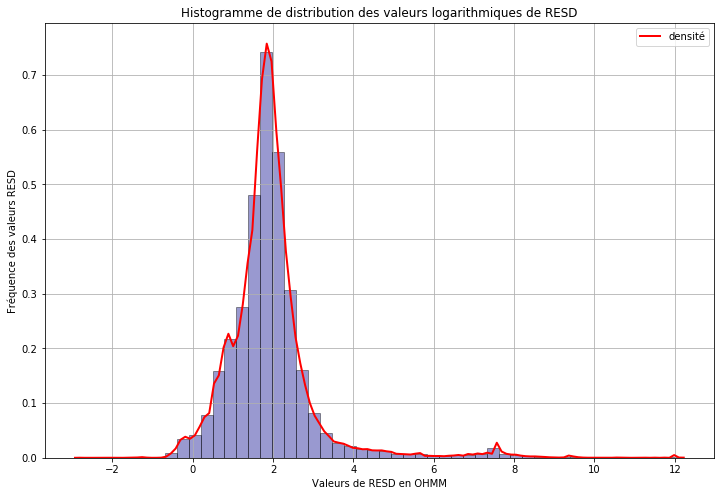

In [170]:
plt.figure(figsize=(12,8))
sns.distplot(np.log(data_geox_ml_resd), color = 'darkblue', hist = True, hist_kws={'edgecolor':'black'},kde=True, kde_kws = {'color': 'red', 'lw': 2, 'label':'densité'})
plt.grid()
plt.xlabel('Valeurs de RESD en OHMM')
plt.ylabel('Fréquence des valeurs RESD')
plt.title('Histogramme de distribution des valeurs logarithmiques de RESD')

Text(0.5, 1.0, 'Histogramme de distribution des RESD par label')

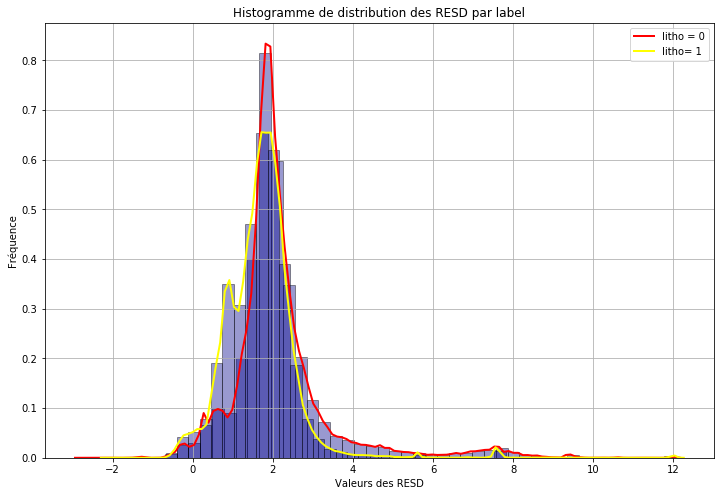

In [171]:
plt.figure(figsize=(12,8))
sns.distplot(np.log(data_geox_ml['RESD'].dropna()[data_geox_ml['LITHO'] == 0]), color = 'darkblue', hist = True, hist_kws={'edgecolor':'black'},kde=True, kde_kws = {'color': 'red', 'lw': 2, 'label':'litho = 0'})
sns.distplot(np.log(data_geox_ml['RESD'].dropna()[data_geox_ml['LITHO'] == 1]), color = 'darkblue', hist = True, hist_kws={'edgecolor':'black'},kde=True, kde_kws = {'color': 'yellow', 'lw': 2, 'label':'litho= 1'})
plt.grid()
plt.xlabel('Valeurs des RESD')
plt.ylabel('Fréquence')
plt.title('Histogramme de distribution des RESD par label')

Text(0, 0.5, 'Valeurs logarithmiques de RESD')

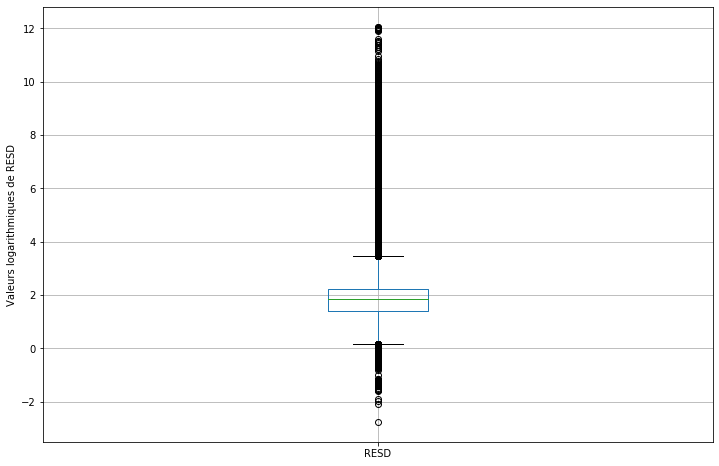

In [172]:
(np.log(data_geox_ml_resd)).plot.box(figsize=(12,8))
plt.grid()
plt.ylabel('Valeurs logarithmiques de RESD')

In [173]:
data_resd = data_geox_ml[['RESD', 'DEPTH_M']].dropna().sort_values(by = 'DEPTH_M')
data_resd.head()

,RESD,DEPTH_M
373504,7.6197,310.017444
96863,7.6197,310.017444
373505,7.4227,310.063896
96864,7.4227,310.063896
96865,7.3099,310.110348


In [174]:
data_resd['RESD'][np.log(data_resd['RESD']) < 0].count()

4314

En observant les graphes ci-dessus, nous notons que certaines valeurs sont négatives (**4186 valeurs**)

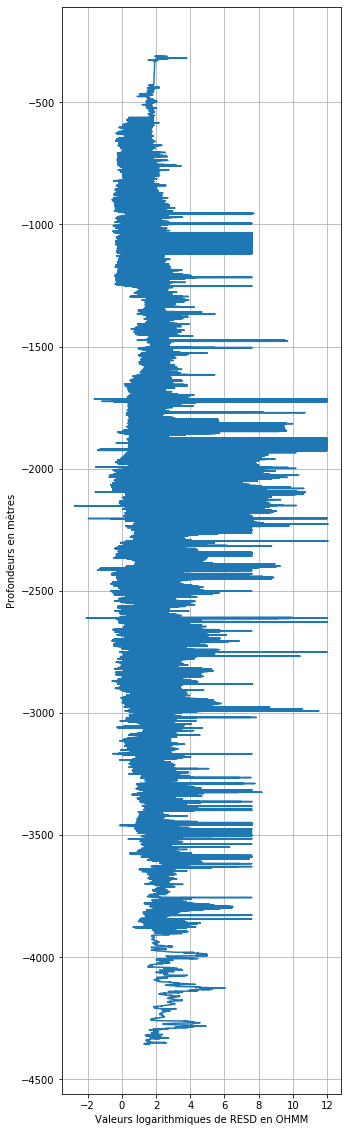

In [175]:
plt.figure(figsize=(5,20))
plt.plot(np.log(data_resd['RESD']), data_resd['DEPTH_M']*-1)
plt.xlabel('Valeurs logarithmiques de RESD en OHMM')
plt.ylabel('Profondeurs en mètres')
plt.grid()

### Remplacement des valeurs négatives par la moyenne

In [176]:
res_resd_2 =data_resd['RESD'][np.log(data_resd['RESD']) > 0].describe()
res_resd_2

count    258287.000000
mean        179.709642
std        4311.231903
min           1.000100
25%           4.210000
50%           6.375000
75%           9.351600
max      173255.093800
Name: RESD, dtype: float64

In [177]:
data_resd['RESD'][(np.log(data_resd['RESD']) < 0 )] = res_resd_2['mean']

In [178]:
data_resd['mean_std'] = res_resd_2['mean'] - data_resd['RESD'] 
data_resd['3_std'] = 3 * res_resd_2['std']

In [179]:
data_resd[data_resd['mean_std'] > data_resd['3_std']].count()

RESD        0
DEPTH_M     0
mean_std    0
3_std       0
dtype: int64

Aucune valeur ne présente un écart à la moyenne supérieur à 3 sigma.

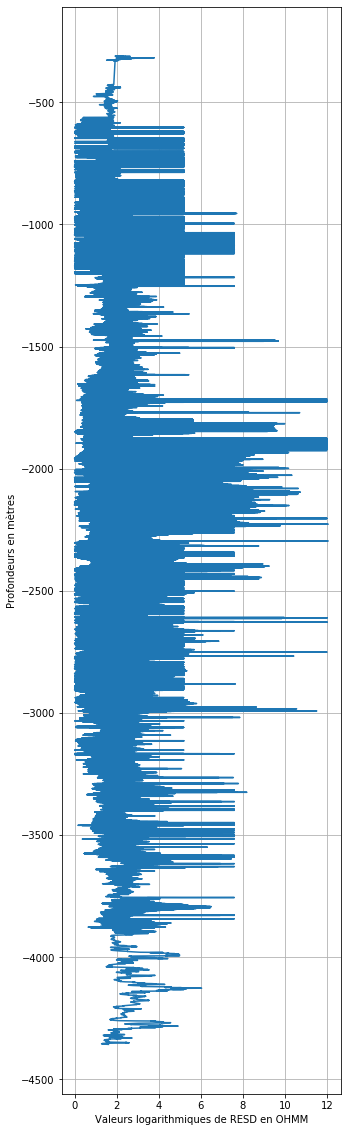

In [180]:
plt.figure(figsize=(5,20))
plt.plot(np.log(data_resd['RESD']), data_resd['DEPTH_M']*-1)
plt.xlabel('Valeurs logarithmiques de RESD en OHMM')
plt.ylabel('Profondeurs en mètres')
plt.grid()

Text(0.5, 1.0, 'Histogramme de distribution des RESD par label')

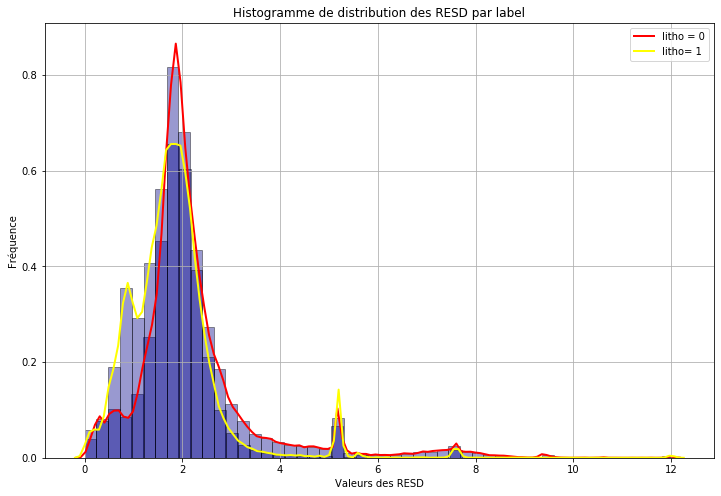

In [181]:
plt.figure(figsize=(12,8))
sns.distplot(np.log(data_resd['RESD'][data_geox_ml['LITHO'] == 0]), color = 'darkblue', hist = True, hist_kws={'edgecolor':'black'},kde=True, kde_kws = {'color': 'red', 'lw': 2, 'label':'litho = 0'})
sns.distplot(np.log(data_resd['RESD'][data_geox_ml['LITHO'] == 1]), color = 'darkblue', hist = True, hist_kws={'edgecolor':'black'},kde=True, kde_kws = {'color': 'yellow', 'lw': 2, 'label':'litho= 1'})
plt.grid()
plt.xlabel('Valeurs des RESD')
plt.ylabel('Fréquence')
plt.title('Histogramme de distribution des RESD par label')

# RESM

In [182]:
data_geox_ml_resm = data_geox_ml['RESM'].dropna()

# le puit 11_30a-A5_jwl_JWL_FILE_318575588 ayant toutes les valeurs RESM à 0 et négatives, on la supprime
data_geox_ml_resm = data_geox_ml_resm[data_geox_ml_resm > 0]

In [183]:
res_resm_1 = data_geox_ml_resm.describe()
res_resm_1

count    218262.000000
mean         54.496874
std         582.246864
min           0.115700
25%           4.250200
50%           7.078800
75%          11.091175
max      170892.500000
Name: RESM, dtype: float64

In [184]:
data_geox_ml[data_geox_ml['RESM'] < 0].tail()

,WELL,DEPTH,GR,CAL,DCOR,DENS,DTC,DTS,PE,PHIN,RESD,RESM,RESS,RESMIC,SP,DEPTH_M,LITHO
238436,11/30A-A5,9022.5,38.0,8.0044,-0.1695,2.497,NaN,NaN,NaN,0.351945,NaN,-970.457,NaN,0.1718,NaN,2750.0580,1
238437,11/30A-A5,9023.0,38.5,8.1523,-0.1440,2.446,NaN,NaN,NaN,0.363980,NaN,-970.456,NaN,0.1747,NaN,2750.2104,1
238438,11/30A-A5,9023.5,40.8,8.3033,-0.1250,2.399,NaN,NaN,NaN,0.356220,NaN,-970.454,NaN,0.2113,NaN,2750.3628,1
238439,11/30A-A5,9024.0,43.1,8.4542,-0.1060,2.352,NaN,NaN,NaN,0.348460,NaN,-970.453,NaN,0.2480,NaN,2750.5152,1
238440,11/30A-A5,9024.5,42.6,8.4604,-0.1910,2.377,NaN,NaN,NaN,0.332450,NaN,-484.335,NaN,0.2779,NaN,2750.6676,1


Text(0.5, 1.0, 'Histogramme de distribution des valeurs logarithmiques de RESM')

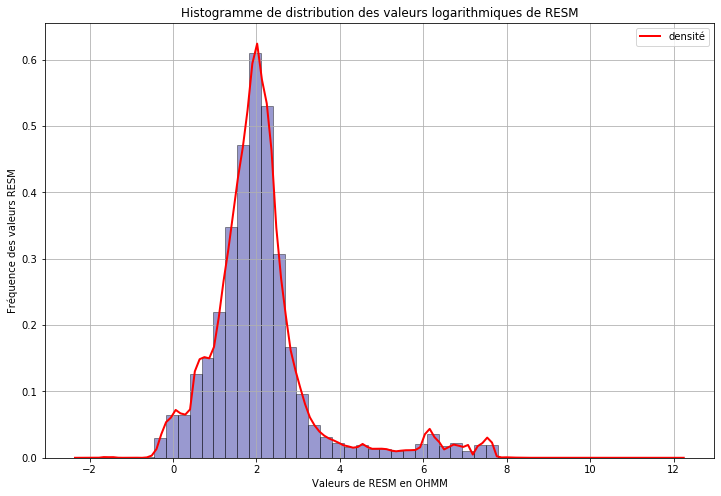

In [185]:
plt.figure(figsize=(12,8))
sns.distplot(np.log(data_geox_ml_resm), color = 'darkblue', hist = True, hist_kws={'edgecolor':'black'},kde=True, kde_kws = {'color': 'red', 'lw': 2, 'label':'densité'})
plt.grid()
plt.xlabel('Valeurs de RESM en OHMM')
plt.ylabel('Fréquence des valeurs RESM')
plt.title('Histogramme de distribution des valeurs logarithmiques de RESM')

Text(0.5, 1.0, 'Histogramme de distribution des RESM par label')

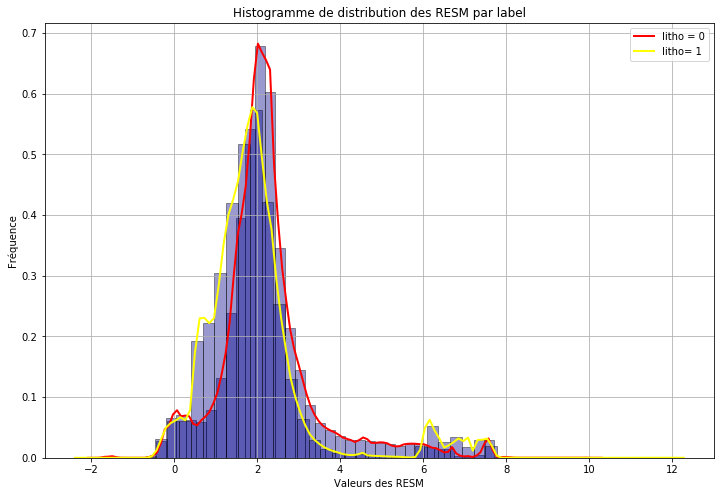

In [186]:
plt.figure(figsize=(12,8))
sns.distplot(np.log(data_geox_ml['RESM'].dropna()[(data_geox_ml['RESM'] > 0) & (data_geox_ml['LITHO'] == 0)])
             , color = 'darkblue', hist = True, hist_kws={'edgecolor':'black'},kde=True, kde_kws = {'color': 'red', 'lw': 2, 'label':'litho = 0'})
sns.distplot(np.log(data_geox_ml['RESM'].dropna()[(data_geox_ml['RESM'] > 0) & (data_geox_ml['LITHO'] == 1)]), color = 'darkblue', hist = True, hist_kws={'edgecolor':'black'},kde=True, kde_kws = {'color': 'yellow', 'lw': 2, 'label':'litho= 1'})
plt.grid()
plt.xlabel('Valeurs des RESM')
plt.ylabel('Fréquence')
plt.title('Histogramme de distribution des RESM par label')

Text(0, 0.5, 'Valeurs logarithmiques de RESM')

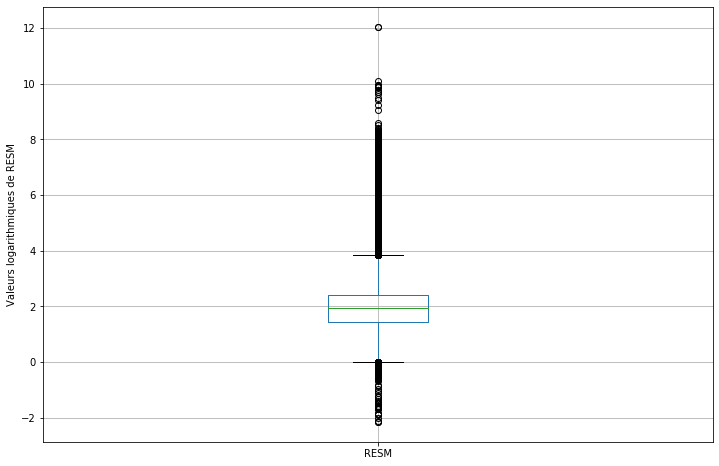

In [187]:
(np.log(data_geox_ml_resm)).plot.box(figsize=(12,8))
plt.grid()
plt.ylabel('Valeurs logarithmiques de RESM')

In [188]:
data_resm = data_geox_ml[['RESM', 'DEPTH_M']].dropna().sort_values(by = 'DEPTH_M')
data_resm = data_resm[data_resm['RESM'] > 0]
data_resm.head()

,RESM,DEPTH_M
373504,7.0208,310.017444
96863,7.0208,310.017444
373505,6.8450,310.063896
96864,6.8450,310.063896
373506,6.7538,310.110348


In [189]:
data_resm['RESM'][np.log(data_resm['RESM']) < 0].count()

4121

En observant les graphes ci-dessus, nous notons que certaines valeurs sont négatives (**4121 valeurs**)

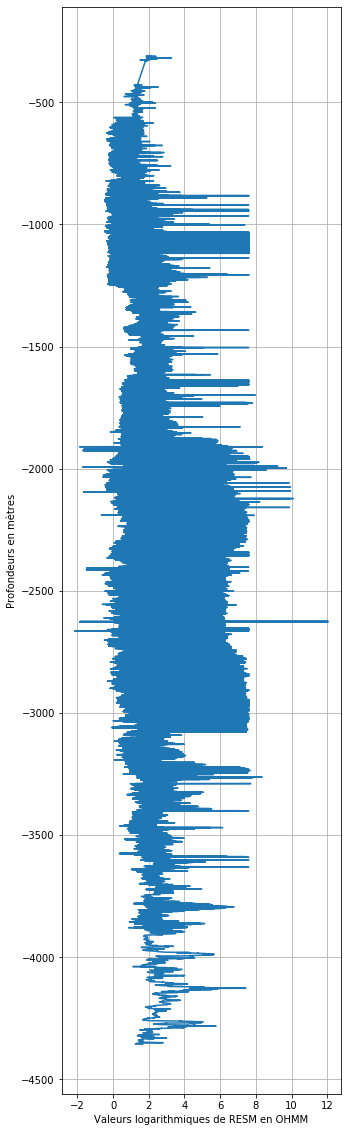

In [190]:
plt.figure(figsize=(5,20))
plt.plot(np.log(data_resm['RESM']), data_resm['DEPTH_M']*-1)
plt.xlabel('Valeurs logarithmiques de RESM en OHMM')
plt.ylabel('Profondeurs en mètres')
plt.grid()

### Remplacement des valeurs négatives par la moyenne

In [191]:
res_resm_2 = data_resm['RESM'][np.log(data_resm['RESM']) > 0].describe()
res_resm_2

count    214126.000000
mean         55.533439
std         587.795026
min           1.000200
25%           4.410200
50%           7.183600
75%          11.228475
max      170892.500000
Name: RESM, dtype: float64

In [192]:
data_resm['RESM'][(np.log(data_resm['RESM']) < 0 )] = res_resm_2['mean']

In [193]:
data_resm['mean_std'] = res_resm_2['mean'] - data_resm['RESM'] 
data_resm['3_std'] = 3 * res_resm_2['std']

In [194]:
data_resm[data_resm['mean_std'] > data_resm['3_std']].count()

RESM        0
DEPTH_M     0
mean_std    0
3_std       0
dtype: int64

Aucune valeur ne présente un écart à la moyenne supérieur à 3 sigma.

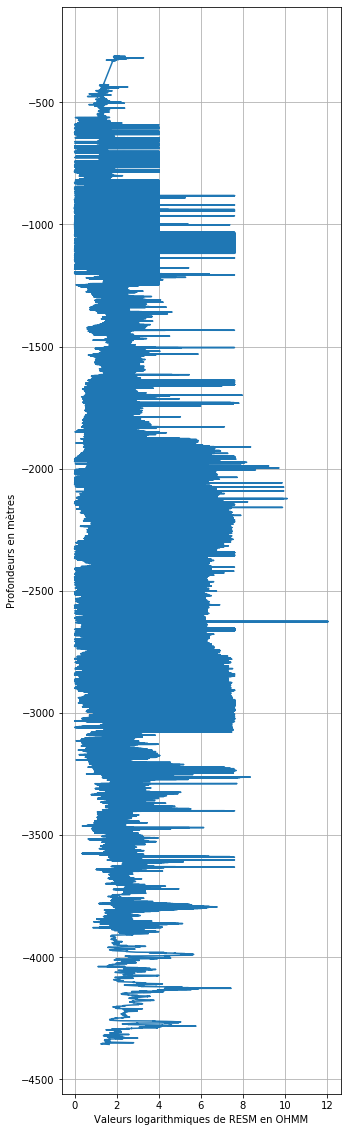

In [195]:
plt.figure(figsize=(5,20))
plt.plot(np.log(data_resm['RESM']), data_resm['DEPTH_M']*-1)
plt.xlabel('Valeurs logarithmiques de RESM en OHMM')
plt.ylabel('Profondeurs en mètres')
plt.grid()

Text(0.5, 1.0, 'Histogramme de distribution des RESM par label')

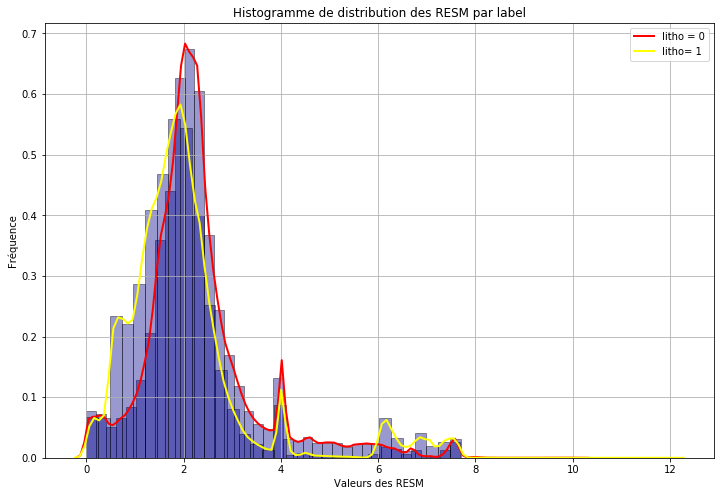

In [196]:
plt.figure(figsize=(12,8))
sns.distplot(np.log(data_resm['RESM'][(data_geox_ml['RESM'] > 0) & (data_geox_ml['LITHO'] == 0)])
             , color = 'darkblue', hist = True, hist_kws={'edgecolor':'black'},kde=True, kde_kws = {'color': 'red', 'lw': 2, 'label':'litho = 0'})
sns.distplot(np.log(data_resm['RESM'][(data_geox_ml['RESM'] > 0) & (data_geox_ml['LITHO'] == 1)]), color = 'darkblue', hist = True, hist_kws={'edgecolor':'black'},kde=True, kde_kws = {'color': 'yellow', 'lw': 2, 'label':'litho= 1'})
plt.grid()
plt.xlabel('Valeurs des RESM')
plt.ylabel('Fréquence')
plt.title('Histogramme de distribution des RESM par label')

# RESS

In [197]:
data_geox_ml_ress = data_geox_ml['RESS'].dropna()

In [198]:
res_ress_1 = data_geox_ml_ress.describe()
res_ress_1

count    134918.000000
mean          9.169660
std          46.156830
min           0.451500
25%           3.582125
50%           5.856900
75%           8.389800
max        2250.093800
Name: RESS, dtype: float64

Text(0.5, 1.0, 'Histogramme de distribution des valeurs logarithmiques de RESS')

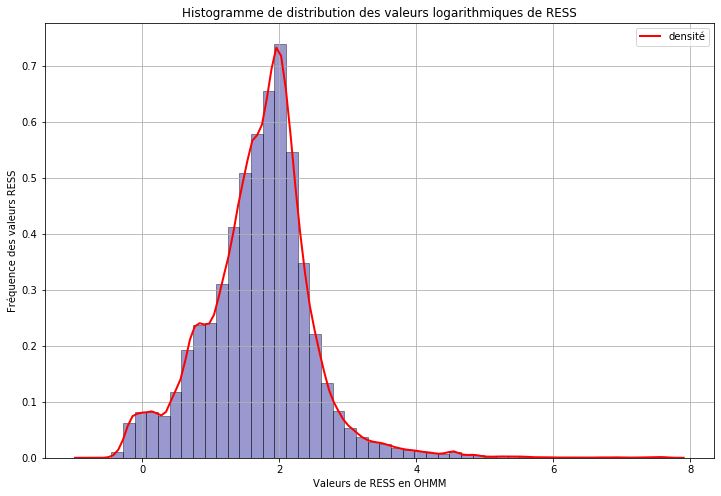

In [199]:
plt.figure(figsize=(12,8))
sns.distplot(np.log(data_geox_ml_ress), color = 'darkblue', hist = True, hist_kws={'edgecolor':'black'},kde=True, kde_kws = {'color': 'red', 'lw': 2, 'label':'densité'})
plt.grid()
plt.xlabel('Valeurs de RESS en OHMM')
plt.ylabel('Fréquence des valeurs RESS')
plt.title('Histogramme de distribution des valeurs logarithmiques de RESS')

Text(0.5, 1.0, 'Histogramme de distribution des RESS par label')

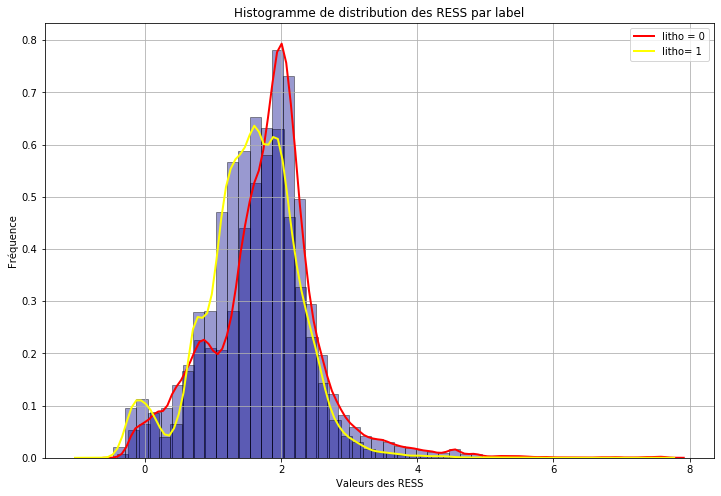

In [200]:
plt.figure(figsize=(12,8))
sns.distplot(np.log(data_geox_ml['RESS'].dropna()[data_geox_ml['LITHO'] == 0]), color = 'darkblue', hist = True, hist_kws={'edgecolor':'black'},kde=True, kde_kws = {'color': 'red', 'lw': 2, 'label':'litho = 0'})
sns.distplot(np.log(data_geox_ml['RESS'].dropna()[data_geox_ml['LITHO'] == 1]), color = 'darkblue', hist = True, hist_kws={'edgecolor':'black'},kde=True, kde_kws = {'color': 'yellow', 'lw': 2, 'label':'litho= 1'})
plt.grid()
plt.xlabel('Valeurs des RESS')
plt.ylabel('Fréquence')
plt.title('Histogramme de distribution des RESS par label')

Text(0, 0.5, 'Valeurs logarithmiques de RESS')

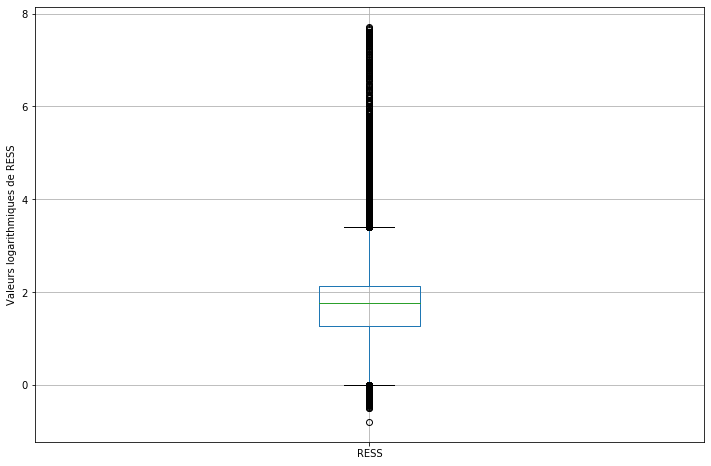

In [201]:
(np.log(data_geox_ml_ress)).plot.box(figsize=(12,8))
plt.grid()
plt.ylabel('Valeurs logarithmiques de RESS')

In [202]:
data_ress = data_geox_ml[['RESS', 'DEPTH_M']].dropna().sort_values(by = 'DEPTH_M')
data_ress.head()

,RESS,DEPTH_M
67743,1.7865,131.0640
67744,1.8030,131.2164
67745,1.7865,131.3688
67746,1.7865,131.5212
67747,1.7865,131.6736


In [203]:
data_ress['RESS'][np.log(data_ress['RESS']) < 0].count()

2888

En observant les graphes ci-dessus, nous notons que certaines valeurs sont négatives (**2517 valeurs**)

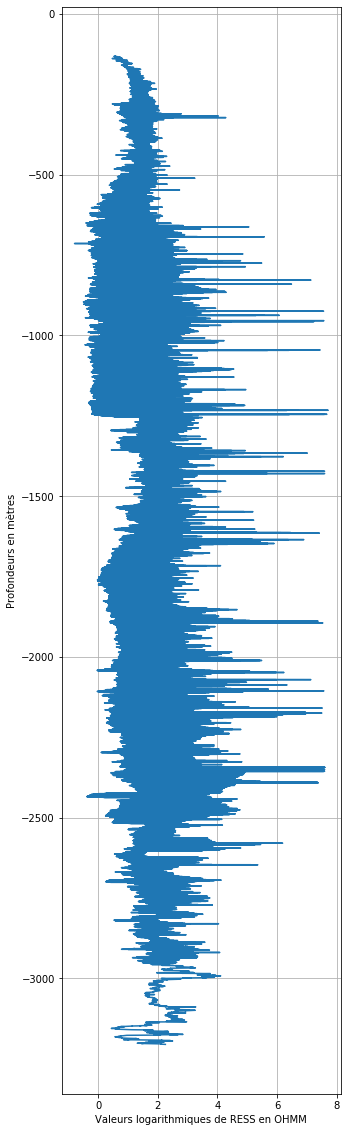

In [204]:
plt.figure(figsize=(5,20))
plt.plot(np.log(data_ress['RESS']), data_ress['DEPTH_M']*-1)
plt.xlabel('Valeurs logarithmiques de RESS en OHMM')
plt.ylabel('Profondeurs en mètres')
plt.grid()

### Remplacement des valeurs négatives par la moyenne

In [205]:
res_ress_2 = data_ress['RESS'][np.log(data_ress['RESS']) > 0].describe()
res_ress_2

count    132020.000000
mean          9.351826
std          46.644124
min           1.000200
25%           3.734400
50%           5.966850
75%           8.472300
max        2250.093800
Name: RESS, dtype: float64

In [206]:
data_ress['RESS'][(np.log(data_ress['RESS']) < 0 )] = res_ress_2['mean']

In [207]:
data_ress['mean_std'] = res_ress_2['mean'] - data_ress['RESS'] 
data_ress['3_std'] = 3 * res_ress_2['std']

In [208]:
data_ress[data_ress['mean_std'] > data_ress['3_std']].count()

RESS        0
DEPTH_M     0
mean_std    0
3_std       0
dtype: int64

Aucune valeur ne présente un écart à la moyenne supérieur à 3 sigma.

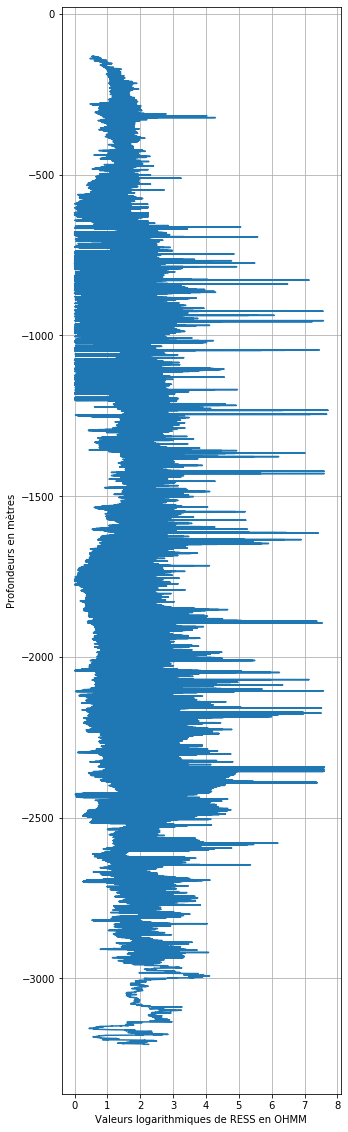

In [209]:
plt.figure(figsize=(5,20))
plt.plot(np.log(data_ress['RESS']), data_ress['DEPTH_M']*-1)
plt.xlabel('Valeurs logarithmiques de RESS en OHMM')
plt.ylabel('Profondeurs en mètres')
plt.grid()

Text(0.5, 1.0, 'Histogramme de distribution des RESS par label')

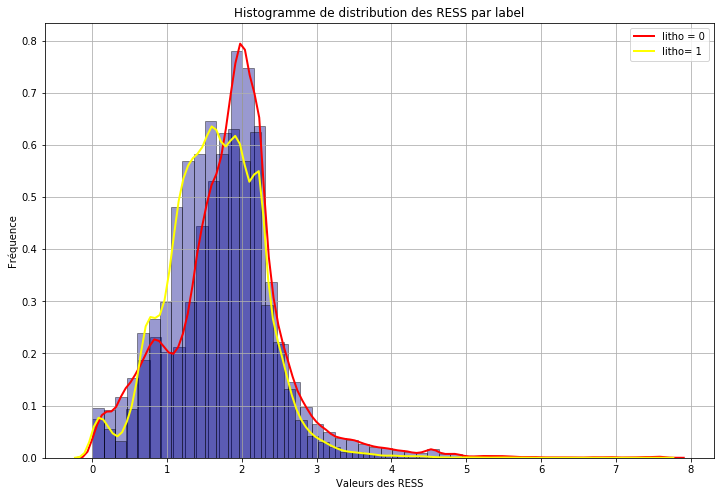

In [210]:
plt.figure(figsize=(12,8))
sns.distplot(np.log(data_ress['RESS'][data_geox_ml['LITHO'] == 0]), color = 'darkblue', hist = True, hist_kws={'edgecolor':'black'},kde=True, kde_kws = {'color': 'red', 'lw': 2, 'label':'litho = 0'})
sns.distplot(np.log(data_ress['RESS'][data_geox_ml['LITHO'] == 1]), color = 'darkblue', hist = True, hist_kws={'edgecolor':'black'},kde=True, kde_kws = {'color': 'yellow', 'lw': 2, 'label':'litho= 1'})
plt.grid()
plt.xlabel('Valeurs des RESS')
plt.ylabel('Fréquence')
plt.title('Histogramme de distribution des RESS par label')

# RESMIC

In [211]:
data_geox_ml_resmic = data_geox_ml['RESMIC'].dropna()

In [212]:
# le puit 11_30a-A5_jwl_JWL_FILE_318575588 ayant toutes les valeurs RESM à 0 et négatives, on la supprime
data_geox_ml_resmic = data_geox_ml_resmic[data_geox_ml_resmic > 0]

In [213]:
res_resmic_1 = data_geox_ml_resmic.describe()
res_resmic_1

count     49486.00000
mean          9.88084
std         475.64659
min           0.05290
25%           1.92310
50%           5.36130
75%           8.65645
max      105713.21880
Name: RESMIC, dtype: float64

In [214]:
data_geox_ml[data_geox_ml['RESMIC'] < 0].head()

,WELL,DEPTH,GR,CAL,DCOR,DENS,DTC,DTS,PE,PHIN,RESD,RESM,RESS,RESMIC,SP,DEPTH_M,LITHO


Text(0.5, 1.0, 'Histogramme de distribution des valeurs logarithmiques de RESMIC')

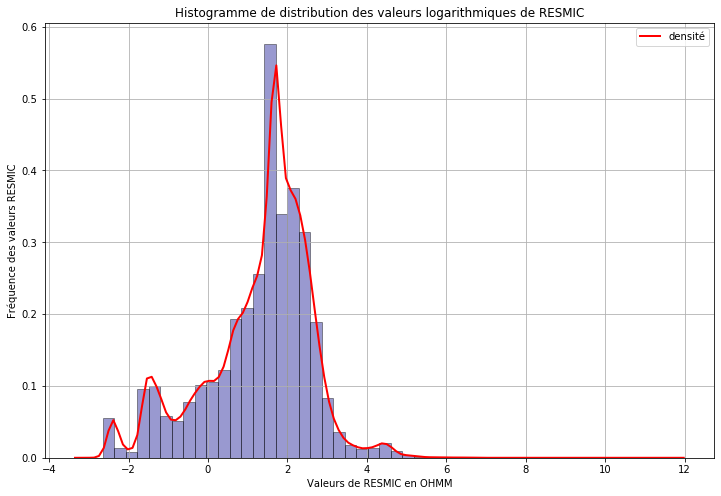

In [215]:
plt.figure(figsize=(12,8))
sns.distplot(np.log(data_geox_ml_resmic), color = 'darkblue', hist = True, hist_kws={'edgecolor':'black'},kde=True, kde_kws = {'color': 'red', 'lw': 2, 'label':'densité'})
plt.grid()
plt.xlabel('Valeurs de RESMIC en OHMM')
plt.ylabel('Fréquence des valeurs RESMIC')
plt.title('Histogramme de distribution des valeurs logarithmiques de RESMIC')

Text(0.5, 1.0, 'Histogramme de distribution des RESMIC par label')

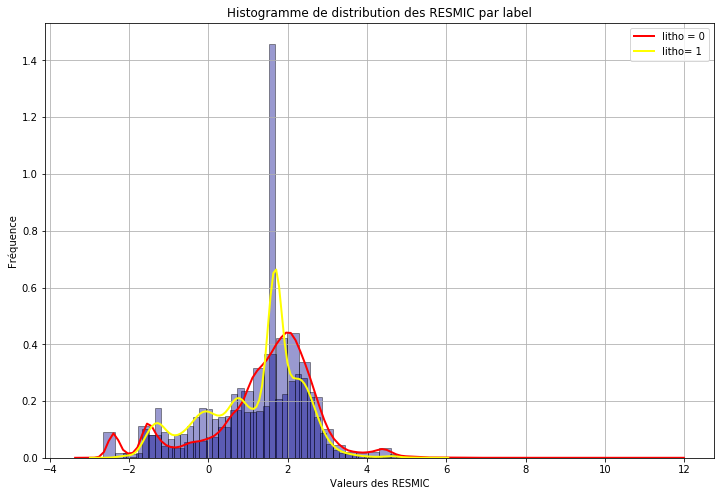

In [216]:
plt.figure(figsize=(12,8))
sns.distplot(np.log(data_geox_ml['RESMIC'].dropna()[(data_geox_ml['RESMIC'] > 0) & (data_geox_ml['LITHO'] == 0)])
             , color = 'darkblue', hist = True, hist_kws={'edgecolor':'black'},kde=True, kde_kws = {'color': 'red', 'lw': 2, 'label':'litho = 0'})
sns.distplot(np.log(data_geox_ml['RESMIC'].dropna()[(data_geox_ml['RESMIC'] > 0) & (data_geox_ml['LITHO'] == 1)]), color = 'darkblue', hist = True, hist_kws={'edgecolor':'black'},kde=True, kde_kws = {'color': 'yellow', 'lw': 2, 'label':'litho= 1'})
plt.grid()
plt.xlabel('Valeurs des RESMIC')
plt.ylabel('Fréquence')
plt.title('Histogramme de distribution des RESMIC par label')

Text(0, 0.5, 'Valeurs logarithmiques de RESMIC')

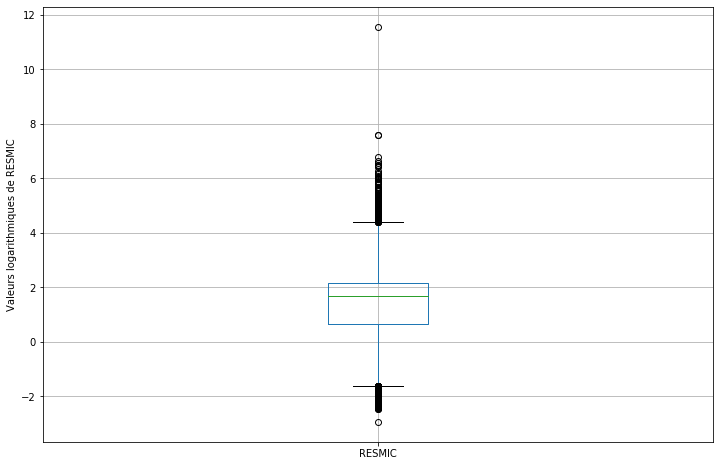

In [217]:
(np.log(data_geox_ml_resmic)).plot.box(figsize=(12,8))
plt.grid()
plt.ylabel('Valeurs logarithmiques de RESMIC')

In [218]:
data_resmic = data_geox_ml[['RESMIC', 'DEPTH_M']].dropna().sort_values(by = 'DEPTH_M')
data_resmic = data_resmic[data_resmic['RESMIC'] > 0]
data_resmic.head()

,RESMIC,DEPTH_M
316506,1.0186,929.4876
316507,1.0186,929.6400
316508,1.0186,929.7924
316509,1.0186,929.9448
316510,1.0186,930.0972


In [219]:
data_resmic['RESMIC'][np.log(data_resmic['RESMIC']) < 0].count()

8296

En observant les graphes ci-dessus, nous notons que certaines valeurs sont négatives (**7112 valeurs**)

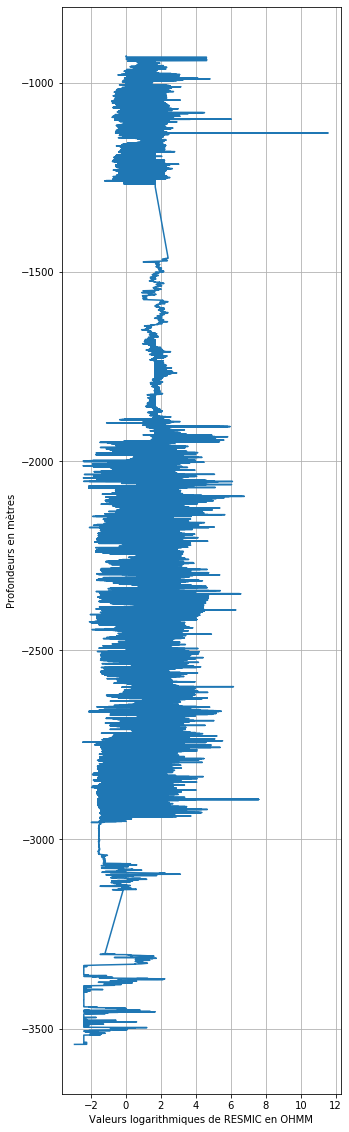

In [220]:
plt.figure(figsize=(5,20))
plt.plot(np.log(data_resmic['RESMIC']), data_resmic['DEPTH_M']*-1)
plt.xlabel('Valeurs logarithmiques de RESMIC en OHMM')
plt.ylabel('Profondeurs en mètres')
plt.grid()

### Remplacement des valeurs négatives par la moyenne

In [221]:
res_resmic_2 = data_resmic['RESMIC'][np.log(data_resmic['RESMIC']) > 0].describe()
res_resmic_2

count     41189.000000
mean         11.784945
std         521.336984
min           1.000200
25%           3.449000
50%           5.410200
75%           9.716300
max      105713.218800
Name: RESMIC, dtype: float64

In [222]:
data_resmic['RESMIC'][(np.log(data_resmic['RESMIC']) < 0 )] = res_resmic_2['mean']

In [223]:
data_resmic['mean_std'] = res_resmic_2['mean'] - data_resmic['RESMIC'] 
data_resmic['3_std'] = 3 * res_resmic_2['std']

In [224]:
data_resmic[data_resmic['mean_std'] > data_resmic['3_std']].count()

RESMIC      0
DEPTH_M     0
mean_std    0
3_std       0
dtype: int64

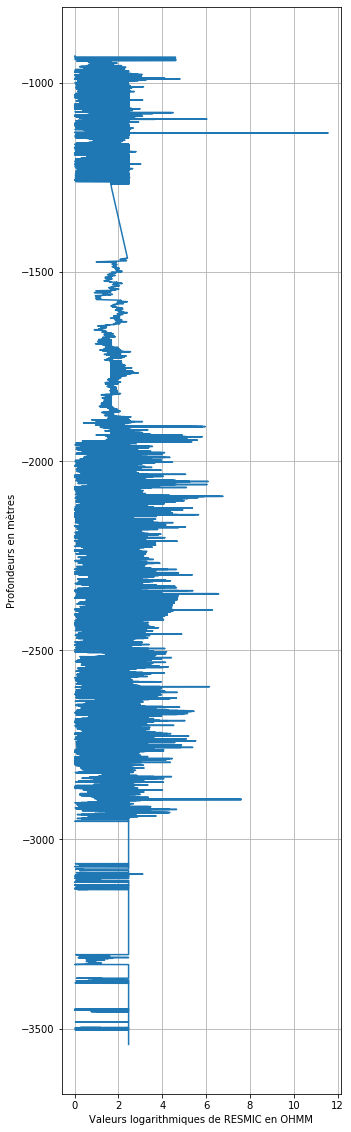

In [225]:
plt.figure(figsize=(5,20))
plt.plot(np.log(data_resmic['RESMIC']), data_resmic['DEPTH_M']*-1)
plt.xlabel('Valeurs logarithmiques de RESMIC en OHMM')
plt.ylabel('Profondeurs en mètres')
plt.grid()

Text(0.5, 1.0, 'Histogramme de distribution des RESMIC par label')

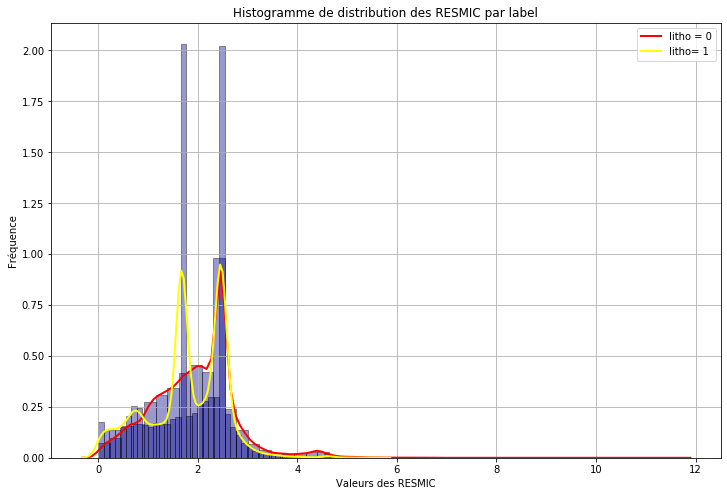

In [226]:
plt.figure(figsize=(12,8))
sns.distplot(np.log(data_resmic['RESMIC'][(data_geox_ml['RESMIC'] > 0) & (data_geox_ml['LITHO'] == 0)])
             , color = 'darkblue', hist = True, hist_kws={'edgecolor':'black'},kde=True, kde_kws = {'color': 'red', 'lw': 2, 'label':'litho = 0'})
sns.distplot(np.log(data_resmic['RESMIC'][(data_geox_ml['RESMIC'] > 0) & (data_geox_ml['LITHO'] == 1)]), color = 'darkblue', hist = True, hist_kws={'edgecolor':'black'},kde=True, kde_kws = {'color': 'yellow', 'lw': 2, 'label':'litho= 1'})
plt.grid()
plt.xlabel('Valeurs des RESMIC')
plt.ylabel('Fréquence')
plt.title('Histogramme de distribution des RESMIC par label')

# SP

In [227]:
data_geox_ml_sp = data_geox_ml['SP'].dropna()

In [228]:
res_sp_1 = data_geox_ml_sp.describe()
res_sp_1

count    2.336820e+05
mean    -8.367840e+02
std      6.319882e+04
min     -8.093696e+06
25%     -1.612500e+01
50%      3.968750e+01
75%      8.450000e+01
max      6.715000e+02
Name: SP, dtype: float64

Text(0.5, 1.0, 'Histogramme de distribution de SP')

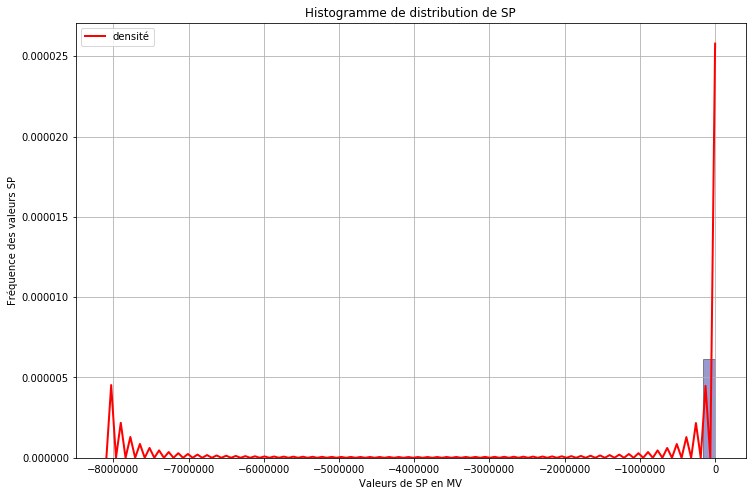

In [229]:
plt.figure(figsize=(12,8))
sns.distplot(data_geox_ml_sp, color = 'darkblue', hist = True, hist_kws={'edgecolor':'black'},kde=True, kde_kws = {'color': 'red', 'lw': 2, 'label':'densité'})
plt.grid()
plt.xlabel('Valeurs de SP en MV')
plt.ylabel('Fréquence des valeurs SP')
plt.title('Histogramme de distribution de SP')

Text(0.5, 1.0, 'Histogramme de distribution des SP par label')

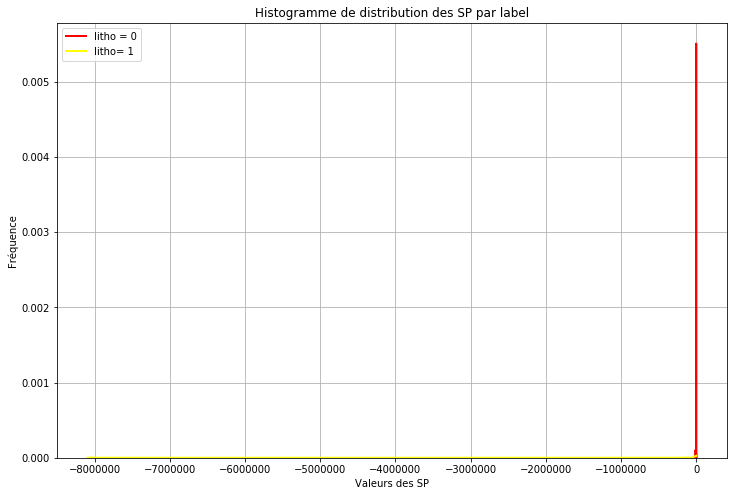

In [230]:
plt.figure(figsize=(12,8))
sns.distplot(data_geox_ml['SP'].dropna()[data_geox_ml['LITHO'] == 0], color = 'darkblue', hist = True, hist_kws={'edgecolor':'black'},kde=True, kde_kws = {'color': 'red', 'lw': 2, 'label':'litho = 0'})
sns.distplot(data_geox_ml['SP'].dropna()[data_geox_ml['LITHO'] == 1], color = 'darkblue', hist = True, hist_kws={'edgecolor':'black'},kde=True, kde_kws = {'color': 'yellow', 'lw': 2, 'label':'litho= 1'})
plt.grid()
plt.xlabel('Valeurs des SP')
plt.ylabel('Fréquence')
plt.title('Histogramme de distribution des SP par label')

Text(0, 0.5, 'Valeurs de SP')

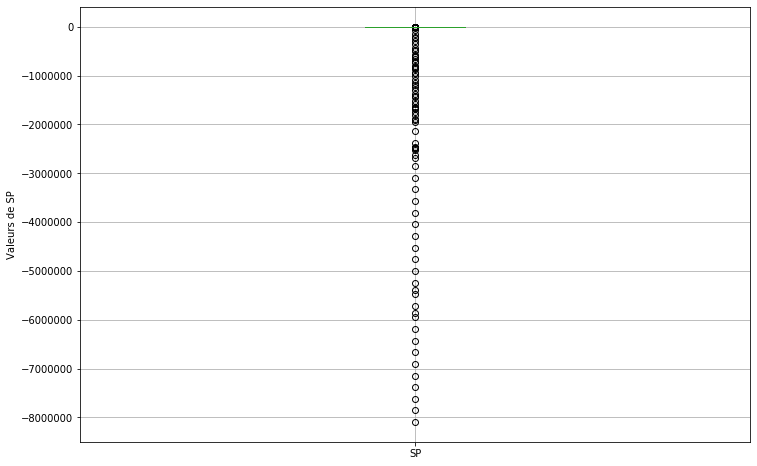

In [231]:
data_geox_ml_sp.plot.box(figsize=(12,8))
plt.grid()
plt.ylabel('Valeurs de SP')

In [232]:
data_geox_ml['SP'][data_geox_ml['SP'] < -200].count()

109

In [233]:
data_sp = data_geox_ml[['SP', 'DEPTH_M']].dropna().sort_values(by = 'DEPTH_M')
data_sp.head()


,SP,DEPTH_M
67743,1.380,131.0640
67744,2.605,131.2164
67745,3.585,131.3688
67746,4.320,131.5212
67747,4.075,131.6736


In [234]:
data_sp['SP'][data_sp['SP'] < -200].count()

109

In [235]:
data_sp['SP'][data_sp['SP'] > 200].count()

12839

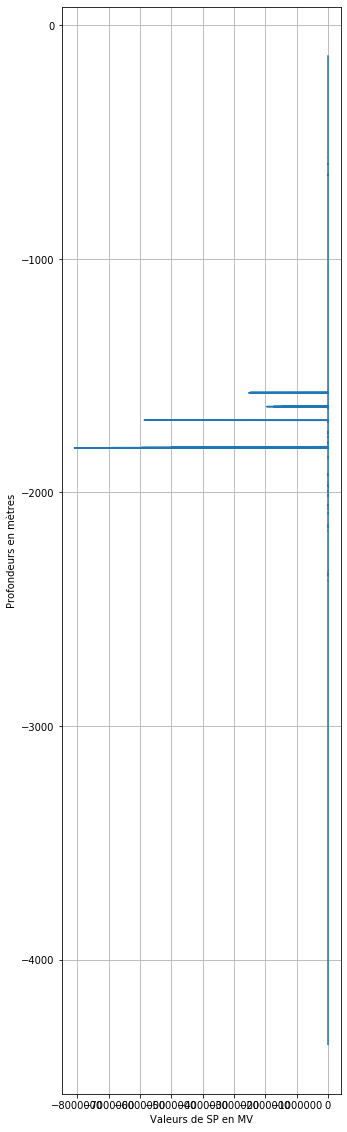

In [236]:
plt.figure(figsize=(5,20))
plt.plot(data_sp['SP'], data_sp['DEPTH_M']*-1)
plt.xlabel('Valeurs de SP en MV')
plt.ylabel('Profondeurs en mètres')
plt.grid()

### Remplacement des valeurs négatives par la moyenne

In [237]:
res_sp_2 = data_sp['SP'][(data_sp['SP'] > -200)].describe()
res_sp_2

count    233573.000000
mean         47.361030
std         113.024838
min        -193.625000
25%         -16.000000
50%          39.750000
75%          84.500000
max         671.500000
Name: SP, dtype: float64

In [238]:
data_sp['SP'][data_sp['SP'] < -200] = res_sp_2['mean']

In [239]:
data_sp['mean_std'] = res_sp_2['mean'] - data_sp['SP'] 
data_sp['3_std'] = 3 * res_sp_2['std']

In [240]:
data_sp[data_sp['mean_std'] > data_sp['3_std']].count()

SP          0
DEPTH_M     0
mean_std    0
3_std       0
dtype: int64

Aucune donnée ne présente un écart à la moyenne supérieure à 3 sigma.

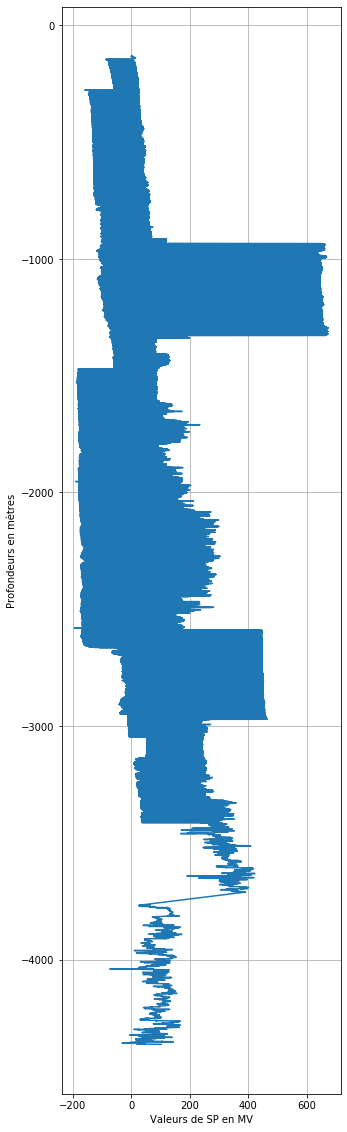

In [241]:
plt.figure(figsize=(5,20))
plt.plot(data_sp['SP'], data_sp['DEPTH_M']*-1)
plt.xlabel('Valeurs de SP en MV')
plt.ylabel('Profondeurs en mètres')
plt.grid()

Text(0.5, 1.0, 'Histogramme de distribution des SP par label')

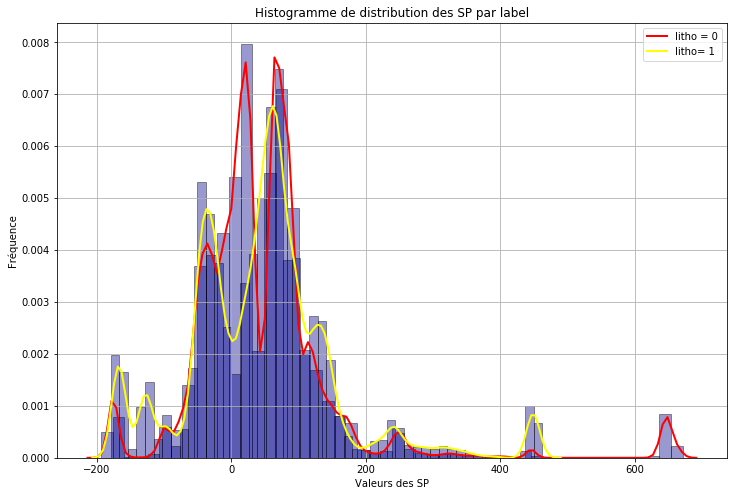

In [242]:
plt.figure(figsize=(12,8))
sns.distplot(data_sp['SP'][data_geox_ml['LITHO'] == 0], color = 'darkblue', hist = True, hist_kws={'edgecolor':'black'},kde=True, kde_kws = {'color': 'red', 'lw': 2, 'label':'litho = 0'})
sns.distplot(data_sp['SP'][data_geox_ml['LITHO'] == 1], color = 'darkblue', hist = True, hist_kws={'edgecolor':'black'},kde=True, kde_kws = {'color': 'yellow', 'lw': 2, 'label':'litho= 1'})
plt.grid()
plt.xlabel('Valeurs des SP')
plt.ylabel('Fréquence')
plt.title('Histogramme de distribution des SP par label')

## SHAP

In [243]:
data_geox_shap = data_geox_ml.drop(columns=['DTS'])

In [244]:
data_geox_shap.head()

,WELL,DEPTH,GR,CAL,DCOR,DENS,DTC,PE,PHIN,RESD,RESM,RESS,RESMIC,SP,DEPTH_M,LITHO
0,10/1-A-10,2094.872,17.2000,8.48605,-0.275,2.426,72.0,NaN,0.168400,0.47420,0.19950,NaN,NaN,-22.2857,2094.872,0
1,10/1-A-10,2095.024,18.7058,8.56870,-0.275,2.392,72.0,NaN,0.182023,0.44160,0.20720,NaN,NaN,-20.0000,2095.024,0
2,10/1-A-10,2095.176,19.3092,8.62140,-0.275,2.378,80.3,NaN,0.171809,0.23975,0.20720,NaN,NaN,-18.2857,2095.176,0
3,10/1-A-10,2095.328,19.1081,8.71425,-0.275,2.330,75.4,NaN,0.154246,0.21250,0.19425,NaN,NaN,-16.5714,2095.328,0
4,10/1-A-10,2095.480,20.3536,8.93990,-0.168,2.216,72.1,NaN,0.141603,0.21080,0.19275,NaN,NaN,-15.1429,2095.480,0


In [245]:
data_geox_shap['GR'] = data_gr['GR']
data_geox_shap['CAL'] = data_cal['CAL']
data_geox_shap['DCOR'] = data_dcor['DCOR']
data_geox_shap['DENS'] = data_dens['DENS']
data_geox_shap['DTC'] = data_dtc['DTC']
data_geox_shap['PE'] = data_pe['PE']
data_geox_shap['PHIN'] = data_phin['PHIN']
data_geox_shap['RESD'] = np.log(data_resd['RESD'])
data_geox_shap['RESM'] = np.log(data_resm['RESM'])
data_geox_shap['RESS'] = np.log(data_ress['RESS'])
data_geox_shap['RESMIC'] = np.log(data_resmic['RESMIC'])
data_geox_shap['SP'] = data_sp['SP']

In [246]:
data_geox_shap.shape

(472079, 16)

In [247]:
data_geox_shap.to_csv('data_hypercube_with_litho.csv')

In [248]:
cols_x = ['GR','CAL','DCOR','DENS','DTC','PE','PHIN','RESD','RESM','RESS','RESMIC','SP']

In [249]:
data_geox_shap[cols_x].to_csv('data_hypercube.csv')

In [250]:
X = data_geox_shap[cols_x]
y = data_geox_shap['LITHO']

In [251]:
model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y), 100)

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [ ]:
shap_values.shape

In [ ]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [ ]:
shap.dependence_plot("GR", shap_values, X)

In [ ]:
shap.dependence_plot("RESD", shap_values, X)

In [ ]:
shap.summary_plot(shap_values, X)

In [ ]:
shap.summary_plot(shap_values, X, plot_type="bar")